In [479]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, mean_squared_error, r2_score,accuracy_score, average_precision_score, precision_recall_curve
from sklearn.metrics import auc as sk_auc, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [412]:
#hosp
admissions = pd.read_csv("data/admissions.csv")
patients = pd.read_csv("data/patients.csv")
transfers = pd.read_csv("data/transfers.csv")
d_labitems = pd.read_csv("data/d_labitems.csv")
labevents = pd.read_csv("data/labevents.csv", nrows=800000)

#icu
icustays = pd.read_csv("data/icustays.csv")
d_items = pd.read_csv("data/d_items.csv")
chartevents = pd.read_csv("data/chartevents.csv", nrows=800000)
inputevents = pd.read_csv("data/inputevents.csv", nrows=800000)
outputevents = pd.read_csv("data/outputevents.csv", nrows=800000)

For this project, we selected a subset of the MIMIC-IV hospital (hosp) and ICU (icu) tables that are most relevant for analyzing patient stays and vital sign dynamics. The admissions, patients, and transfers tables provide essential demographic and administrative information, including patient identifiers, admission times, and movement across hospital units, which are necessary to contextualize each ICU stay. The labevents and d_labitems tables contain laboratory measurements and their definitions, offering valuable clinical signals that can be used for model features. On the ICU side, the icustays table defines the time boundaries of each ICU stay, while d_items provides metadata for recorded events. The chartevents table contains high-resolution time-series vital signs and clinical observations, which are crucial for building predictive monitoring models. Finally, inputevents and outputevents capture fluid input and output volumes, offering additional physiological data that can help model patient status and detect deterioration trends.

In [413]:
for name, df in {
    "admissions": admissions,
    "patients": patients,
    "icustays": icustays,
    "d_items": d_items,
    "chartevents": chartevents,
    "inputevents": inputevents,
    "outputevents": outputevents,
    "labevetns" : labevents,
    "d_labitems" : d_labitems,
}.items():
    print(f"\n=== {name.upper()} ===")
    print(df.shape)
    print(df.columns)
    print(df.head(3))



=== ADMISSIONS ===
(546028, 16)
Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag'],
      dtype='object')
   subject_id   hadm_id            admittime            dischtime deathtime  \
0    10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00       NaN   
1    10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00       NaN   
2    10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00       NaN   

  admission_type admit_provider_id      admission_location discharge_location  \
0         URGENT            P49AFC  TRANSFER FROM HOSPITAL               HOME   
1       EW EMER.            P784FA          EMERGENCY ROOM               HOME   
2       EW EMER.            P19UTS          EMERGENCY ROOM            HOSPICE   

  insurance language marit

In [414]:
# admissions
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])

# icustays
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

# chartevents / inputevents / outputevents
for df in [chartevents, inputevents, outputevents]:
    for col in ['charttime', 'storetime', 'starttime', 'endtime']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')


In [415]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [416]:
# Example for chartevents
#chartevents = chartevents.drop(columns=['warning', 'error', 'valuenum', 'valueuom'], errors='ignore')

# Drop rows with missing critical IDs
#chartevents = chartevents.dropna(subset=['subject_id', 'hadm_id', 'stay_id', 'charttime'])


In [417]:
# Merge icustays with patient demographics
icu_demo = icustays.merge(patients, on="subject_id", how="left").merge(
    admissions, on=["subject_id", "hadm_id"], how="left"
)

print(icu_demo.head(3))


   subject_id   hadm_id   stay_id                      first_careunit  \
0    10000032  29079034  39553978  Medical Intensive Care Unit (MICU)   
1    10000690  25860671  37081114  Medical Intensive Care Unit (MICU)   
2    10000980  26913865  39765666  Medical Intensive Care Unit (MICU)   

                        last_careunit              intime             outtime  \
0  Medical Intensive Care Unit (MICU) 2180-07-23 14:00:00 2180-07-23 23:50:47   
1  Medical Intensive Care Unit (MICU) 2150-11-02 19:37:00 2150-11-06 17:03:17   
2  Medical Intensive Care Unit (MICU) 2189-06-27 08:42:00 2189-06-27 20:38:27   

        los gender  anchor_age  ...  admit_provider_id admission_location  \
0  0.410266      F          52  ...             P06OTX     EMERGENCY ROOM   
1  3.893252      F          86  ...             P26QQ4     EMERGENCY ROOM   
2  0.497535      F          73  ...             P06OTX     EMERGENCY ROOM   

  discharge_location insurance language marital_status  \
0              

In [418]:
# For efficiency, make index on stay_id
icustays_idx = icustays.set_index('stay_id')[['intime', 'outtime']]

def filter_to_icu_window(row):
    stay_id = row['stay_id']
    if stay_id in icustays_idx.index:
        t_in = icustays_idx.loc[stay_id, 'intime']
        t_out = icustays_idx.loc[stay_id, 'outtime']
        return (row['charttime'] >= t_in) and (row['charttime'] <= t_out)
    return False

chartevents = chartevents[chartevents.apply(filter_to_icu_window, axis=1)]


In [419]:
chartevents.head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
3,10000032,29079034,39553978,18704.0,2180-07-23 14:00:00,2180-07-23 14:18:00,220048,SR (Sinus Rhythm),NaN,NaN,0.0
4,10000032,29079034,39553978,18704.0,2180-07-23 14:00:00,2180-07-23 14:18:00,224642,Oral,NaN,NaN,0.0
5,10000032,29079034,39553978,18704.0,2180-07-23 14:00:00,2180-07-23 14:18:00,224650,NaN,NaN,NaN,0.0
6,10000032,29079034,39553978,18704.0,2180-07-23 14:00:00,2180-07-23 14:20:00,223761,98.7,98.7,°F,0.0
7,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220179,84,84.0,mmHg,0.0


In [420]:
df = chartevents[pd.to_numeric(chartevents['valuenum'], errors='coerce').notnull()]

# Convert Fahrenheit to Celsius where needed
mask_f = df['valueuom'] == '°F'
df.loc[mask_f, 'valuenum'] = (df.loc[mask_f, 'valuenum'] - 32) * 5/9
df.loc[mask_f, 'valueuom'] = '°C'

temp = df[df['valueuom'] == '°C']
summary = temp['valuenum'].describe()
print(summary)

count    6358.000000
mean       36.852095
std        13.474523
min         3.000000
25%        36.611111
50%        37.000000
75%        37.111111
max      1100.000000
Name: valuenum, dtype: float64


## Admission

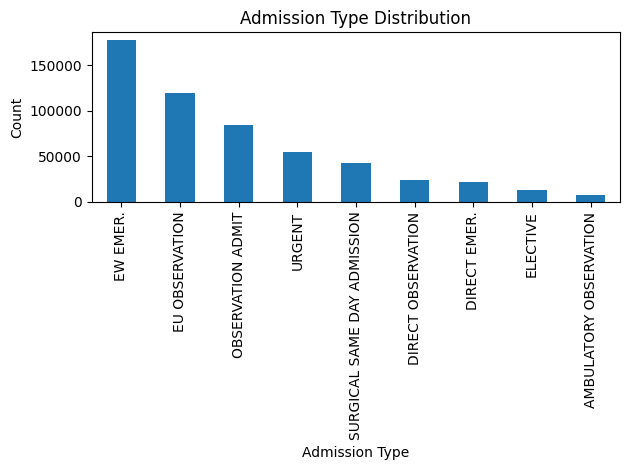

In [421]:
#Admission type

counts = admissions["admission_type"].value_counts()

plt.figure()
counts.plot(kind="bar")
plt.title("Admission Type Distribution")
plt.xlabel("Admission Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

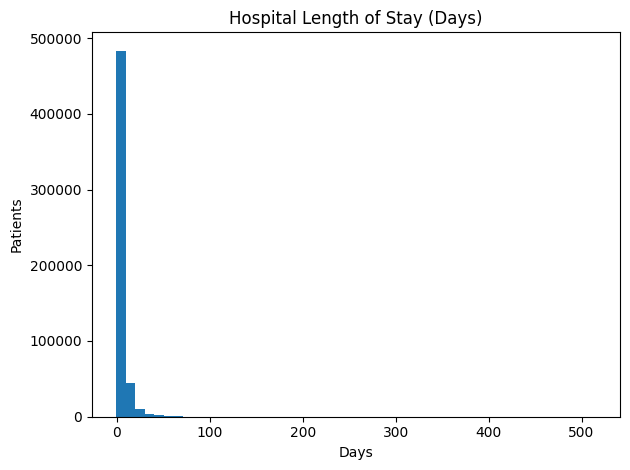

In [422]:
#Length of hospital stay (days)

los_days = (admissions["dischtime"] - admissions["admittime"]).dt.total_seconds() / 86400.0
los_days = los_days[np.isfinite(los_days)]

plt.figure()
plt.hist(los_days, bins=50)
plt.title("Hospital Length of Stay (Days)")
plt.xlabel("Days")
plt.ylabel("Patients")
plt.tight_layout()
plt.show()

## icustays

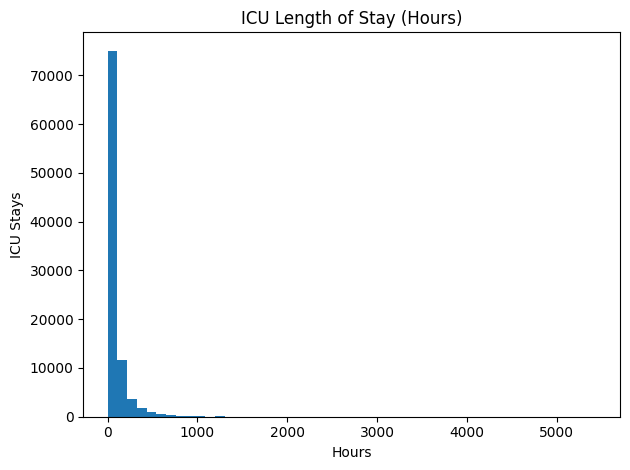

In [423]:
#ICU length of stay (hours)

icu_hours = (icustays["outtime"] - icustays["intime"]).dt.total_seconds() / 3600.0
icu_hours = icu_hours[np.isfinite(icu_hours) & (icu_hours >= 0)]

plt.figure()
plt.hist(icu_hours, bins=50)
plt.title("ICU Length of Stay (Hours)")
plt.xlabel("Hours")
plt.ylabel("ICU Stays")
plt.tight_layout()
plt.show()

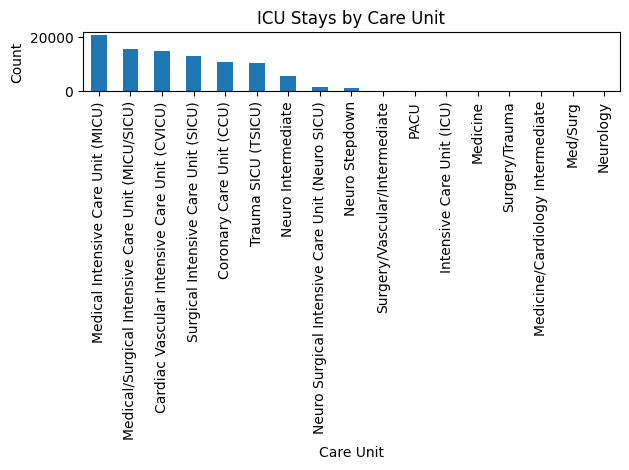

In [424]:
#ICU type (first_careunit)

unit_counts = icustays["first_careunit"].value_counts()

plt.figure()
unit_counts.plot(kind="bar")
plt.title("ICU Stays by Care Unit")
plt.xlabel("Care Unit")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## patients

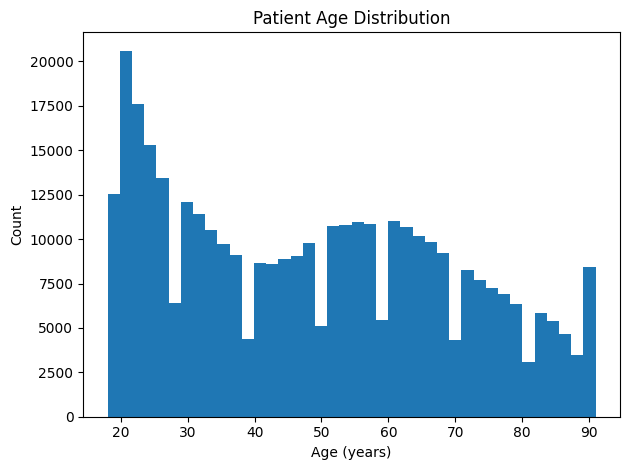

In [425]:
#Age distribution (anchor_age)

ages = patients["anchor_age"].dropna()

plt.figure()
plt.hist(ages, bins=40)
plt.title("Patient Age Distribution")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

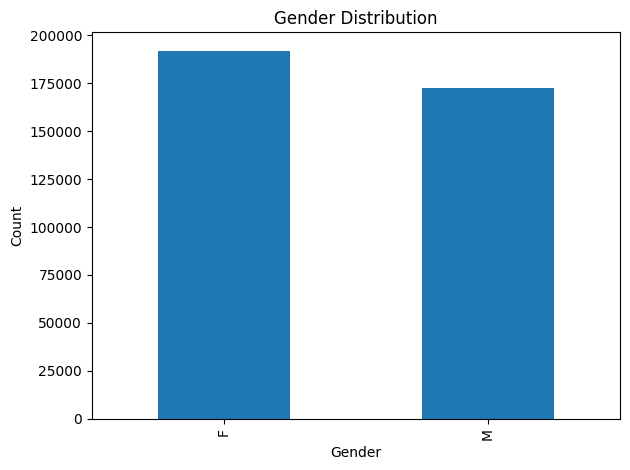

In [426]:
#Gender count

gender_counts = patients["gender"].value_counts()

plt.figure()
gender_counts.plot(kind="bar")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## chartevents and d_items

<Figure size 640x480 with 0 Axes>

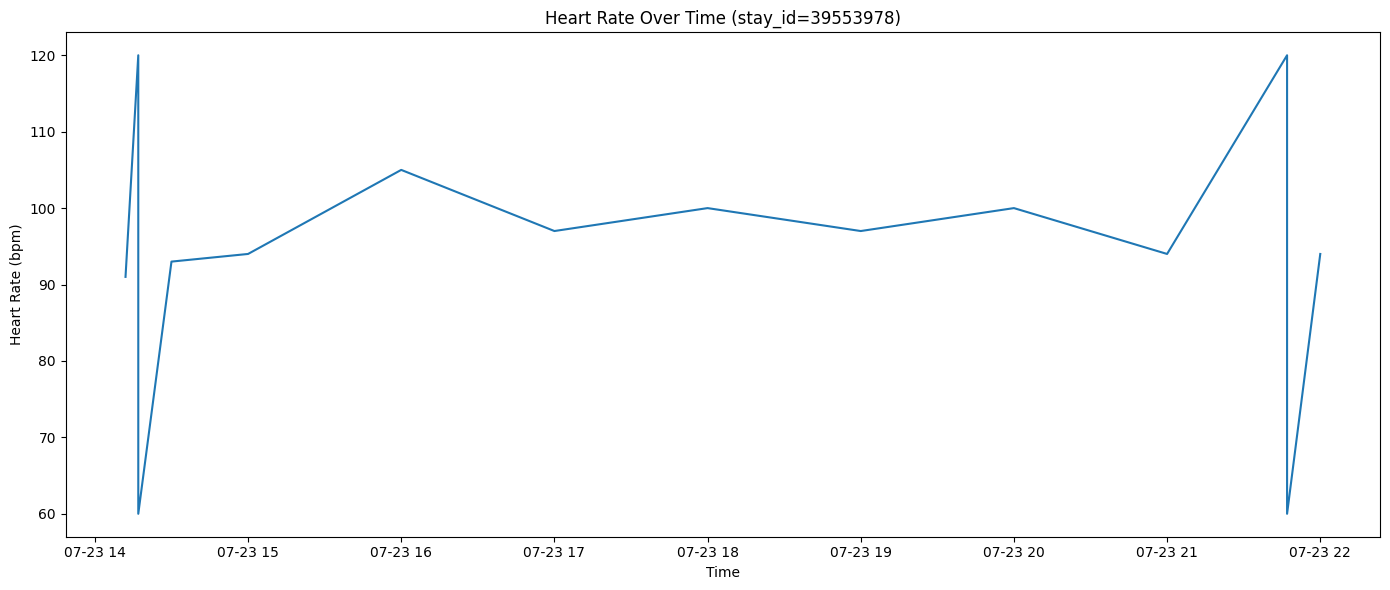

In [427]:
#Heart Rate over time for one stay

hr_ids = d_items[d_items["label"].str.contains("Heart Rate", case=False, na=False)]["itemid"].unique()

sample_stays = chartevents["stay_id"].dropna().unique()
if len(sample_stays) == 0:
    raise SystemExit("No stay_id found in the sample. Increase nrows or pre-filter.")
one_stay = sample_stays[0]

hr = chartevents[(chartevents["stay_id"] == one_stay) & (chartevents["itemid"].isin(hr_ids))]
hr = hr.sort_values("charttime")

plt.figure()
plt.figure(figsize=(14, 6))
plt.plot(hr["charttime"], hr["valuenum"])
plt.title(f"Heart Rate Over Time (stay_id={one_stay})")
plt.xlabel("Time")
plt.ylabel("Heart Rate (bpm)")
plt.tight_layout()
plt.show()

In [428]:
cols = d_items['label'].unique().tolist()
#cols

## search in d_items

In [429]:
filtered = d_items[d_items['label'].str.contains('blood pressure', case=False, na=False)]
filtered

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
6,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0
7,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0
8,220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
9,220056,Arterial Blood Pressure Alarm - Low,ABP Alarm - Low,chartevents,Alarms,mmHg,Numeric,NaN,NaN
10,220058,Arterial Blood Pressure Alarm - High,ABP Alarm - High,chartevents,Alarms,mmHg,Numeric,NaN,NaN
24,220179,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
25,220180,Non Invasive Blood Pressure diastolic,NBPd,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
26,220181,Non Invasive Blood Pressure mean,NBPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
330,223751,Non-Invasive Blood Pressure Alarm - High,NBP Alarm - High,chartevents,Alarms,mmHg,Numeric,NaN,NaN
331,223752,Non-Invasive Blood Pressure Alarm - Low,NBP Alarm - Low,chartevents,Alarms,mmHg,Numeric,NaN,NaN


In [430]:
filtered2 = d_items[d_items['abbreviation'].str.contains('SpO2', case=False, na=False)]
filtered2

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
36,220277,O2 saturation pulseoxymetry,SpO2,chartevents,Respiratory,%,Numeric,NaN,NaN
345,223769,O2 Saturation Pulseoxymetry Alarm - High,SpO2 Alarm - High,chartevents,Alarms,%,Numeric,NaN,NaN
346,223770,O2 Saturation Pulseoxymetry Alarm - Low,SpO2 Alarm - Low,chartevents,Alarms,%,Numeric,NaN,NaN
1810,226253,SpO2 Desat Limit,SpO2 Desat Limit,chartevents,Alarms,%,Numeric,NaN,NaN
3920,229862,Forehead SpO2 Sensor in Place,Forehead SpO2 Sensor in Place,chartevents,Routine Vital Signs,NaN,Checkbox,NaN,NaN


In [431]:
filtered3 = d_items[d_items['label'].str.contains('Temperature Celsius', case=False, na=False)]
filtered3

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
338,223762,Temperature Celsius,Temperature C,chartevents,Routine Vital Signs,°C,Numeric,NaN,NaN


In [432]:
HR = chartevents[chartevents['itemid'] == 220045].copy()
HR.head(10)

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
10,10000032,29079034,39553978,18704.0,2180-07-23 14:12:00,2180-07-23 14:17:00,220045,91,91.0,bpm,0.0
94,10000032,29079034,39553978,18704.0,2180-07-23 14:30:00,2180-07-23 14:43:00,220045,93,93.0,bpm,0.0
160,10000032,29079034,39553978,18704.0,2180-07-23 15:00:00,2180-07-23 15:34:00,220045,94,94.0,bpm,0.0
177,10000032,29079034,39553978,18704.0,2180-07-23 16:00:00,2180-07-23 16:05:00,220045,105,105.0,bpm,0.0
206,10000032,29079034,39553978,18704.0,2180-07-23 17:00:00,2180-07-23 17:01:00,220045,97,97.0,bpm,0.0
247,10000032,29079034,39553978,18704.0,2180-07-23 18:00:00,2180-07-23 18:16:00,220045,100,100.0,bpm,0.0
309,10000032,29079034,39553978,20925.0,2180-07-23 19:00:00,2180-07-23 19:59:00,220045,97,97.0,bpm,0.0
319,10000032,29079034,39553978,20925.0,2180-07-23 20:00:00,2180-07-23 21:01:00,220045,100,100.0,bpm,0.0
360,10000032,29079034,39553978,20925.0,2180-07-23 21:00:00,2180-07-23 21:01:00,220045,94,94.0,bpm,0.0
459,10000032,29079034,39553978,76052.0,2180-07-23 22:00:00,2180-07-23 22:15:00,220045,94,94.0,bpm,0.0


## inputevents

<Figure size 640x480 with 0 Axes>

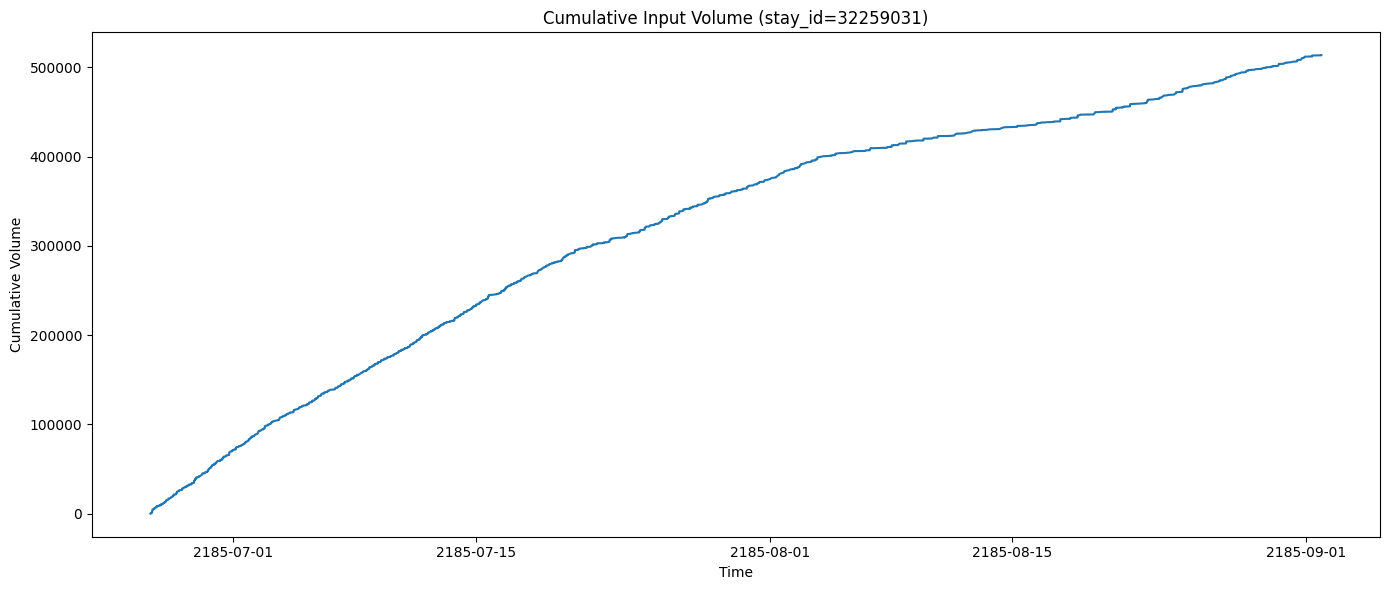

In [433]:
#Cumulative input volume over an ICU stay

# pick a stay with data
stay_counts = inputevents["stay_id"].value_counts()
if len(stay_counts) == 0:
    raise SystemExit("No inputevents in sample. Increase nrows.")
one_stay_in = stay_counts.index[0]

df_in = inputevents[inputevents["stay_id"] == one_stay_in].copy()
# Choose a numeric volume column present in your file (common: 'amount' or 'volume')
vol_col = "amount" if "amount" in df_in.columns else ("volume" if "volume" in df_in.columns else None)
if vol_col is None:
    raise SystemExit("No volume/amount column found in inputevents.")

df_in = df_in.sort_values("starttime")
df_in["cum_volume"] = df_in[vol_col].fillna(0).cumsum()

plt.figure()
plt.figure(figsize=(14, 6))
plt.plot(df_in["starttime"], df_in["cum_volume"])
plt.title(f"Cumulative Input Volume (stay_id={one_stay_in})")
plt.xlabel("Time")
plt.ylabel("Cumulative Volume")
plt.tight_layout()
plt.show()

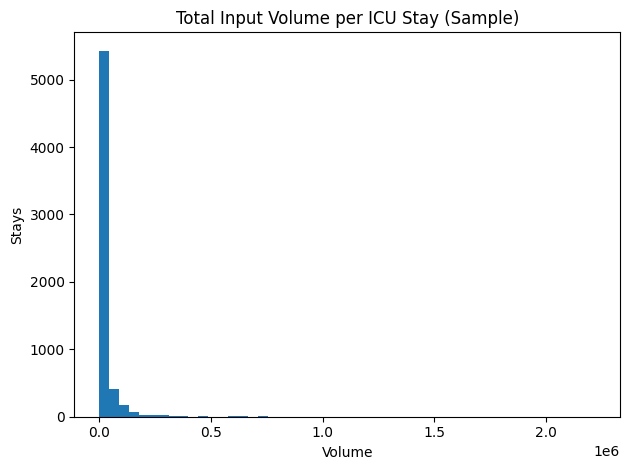

In [434]:
# Total input volume per stay (sample)

grp = inputevents.dropna(subset=[vol_col]).groupby("stay_id")[vol_col].sum()

plt.figure()
plt.hist(grp.values, bins=50)
plt.title("Total Input Volume per ICU Stay (Sample)")
plt.xlabel("Volume")
plt.ylabel("Stays")
plt.tight_layout()
plt.show()

## outputevents

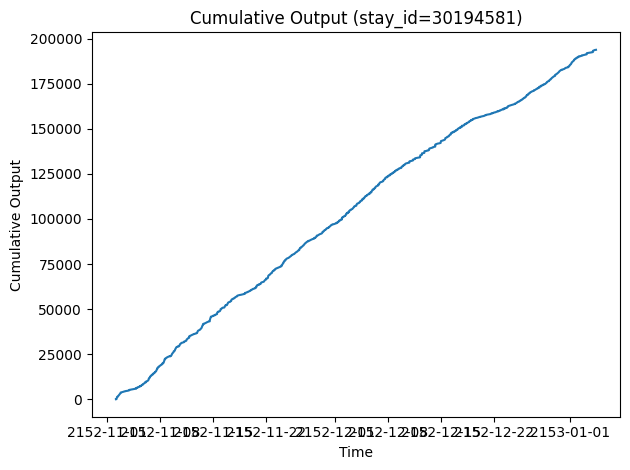

In [435]:
# Cumulative urine output over an ICU stay

stay_counts = outputevents["stay_id"].value_counts()
if len(stay_counts) == 0:
    raise SystemExit("No outputevents in sample. Increase nrows.")
one_stay_out = stay_counts.index[0]

df_out = outputevents[outputevents["stay_id"] == one_stay_out].copy()
val_col = "value" if "value" in df_out.columns else None
if val_col is None:
    raise SystemExit("No numeric 'value' column found in outputevents.")

df_out = df_out.sort_values("charttime")
df_out["cum_out"] = df_out[val_col].fillna(0).cumsum()

plt.figure()
plt.plot(df_out["charttime"], df_out["cum_out"])
plt.title(f"Cumulative Output (stay_id={one_stay_out})")
plt.xlabel("Time")
plt.ylabel("Cumulative Output")
plt.tight_layout()
plt.show()


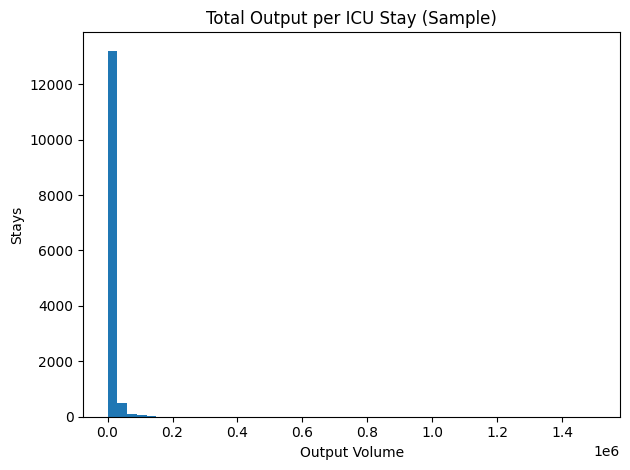

In [436]:
# Total input volume per stay (sample)

grp_out = outputevents.dropna(subset=[val_col]).groupby("stay_id")[val_col].sum()

plt.figure()
plt.hist(grp_out.values, bins=50)
plt.title("Total Output per ICU Stay (Sample)")
plt.xlabel("Output Volume")
plt.ylabel("Stays")
plt.tight_layout()
plt.show()

## transfers

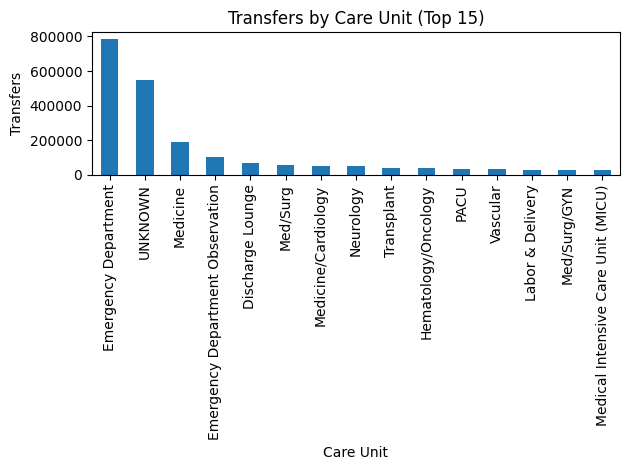

In [437]:
counts = transfers["careunit"].value_counts().head(15)

plt.figure()
counts.plot(kind="bar")
plt.title("Transfers by Care Unit (Top 15)")
plt.xlabel("Care Unit")
plt.ylabel("Transfers")
plt.tight_layout()
plt.show()


In [438]:
def plot_missing_heatmap(df: pd.DataFrame, title: str, max_cols=40, sample_rows=4000):
    """
    Visualizes missingness with a Matplotlib heatmap.
    - Down-samples rows to speed up rendering on huge tables.
    - Limits columns to first `max_cols` for readability.
    """
    if df.empty:
        print(f"{title}: DataFrame is empty.")
        return
    
    # choose columns (first max_cols) and sample rows
    cols = df.columns[:max_cols]
    tmp = df[cols]
    if len(tmp) > sample_rows:
        tmp = tmp.sample(sample_rows, random_state=42).sort_index()
    
    miss = tmp.isna().astype(int)

    plt.figure(figsize=(12, 6))
    plt.imshow(miss.T, aspect='auto', interpolation='nearest', cmap='Greys')
    plt.title(f"{title} — Missingness Heatmap (rows≈{len(tmp)}, cols={len(cols)})")
    plt.xlabel("Row sample")
    plt.ylabel("Columns")
    plt.yticks(range(len(cols)), cols)
    plt.colorbar(label="1 = missing, 0 = present")
    plt.tight_layout()
    plt.show()

def plot_missing_bar(df: pd.DataFrame, title: str, top_n=30):
    """
    Bar chart of percent missing per column (top N most-missing).
    """
    if df.empty:
        print(f"{title}: DataFrame is empty.")
        return
    
    pct = df.isna().mean().sort_values(ascending=False)[:top_n] * 100
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(pct)), pct.values)
    plt.xticks(range(len(pct)), pct.index, rotation=45, ha='right')
    plt.ylabel("% Missing")
    plt.title(f"{title} — Top {top_n} Columns by % Missing")
    plt.tight_layout()
    plt.show()


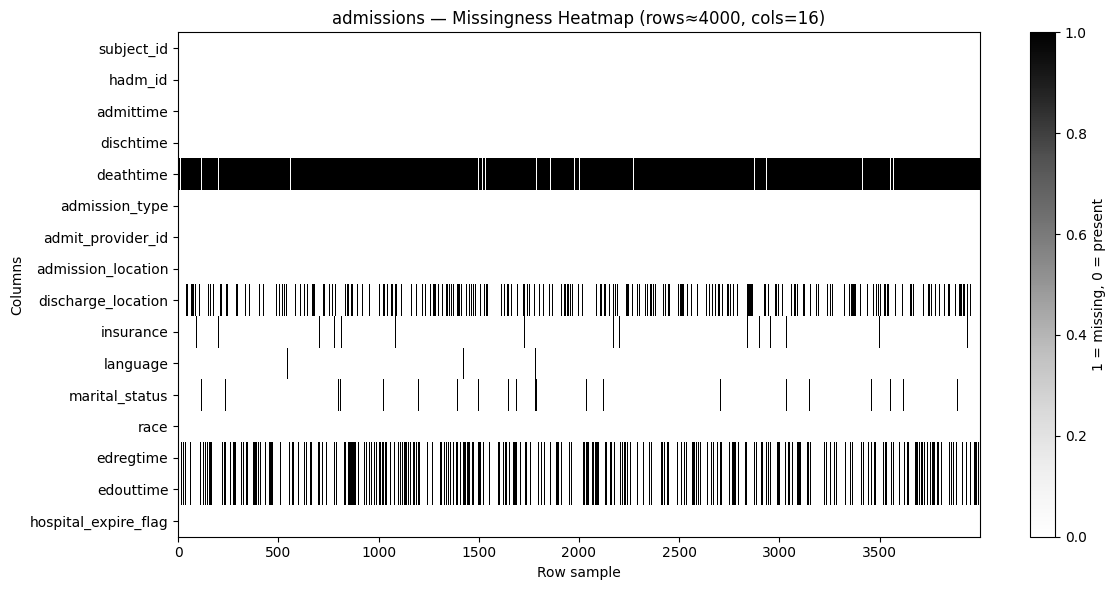

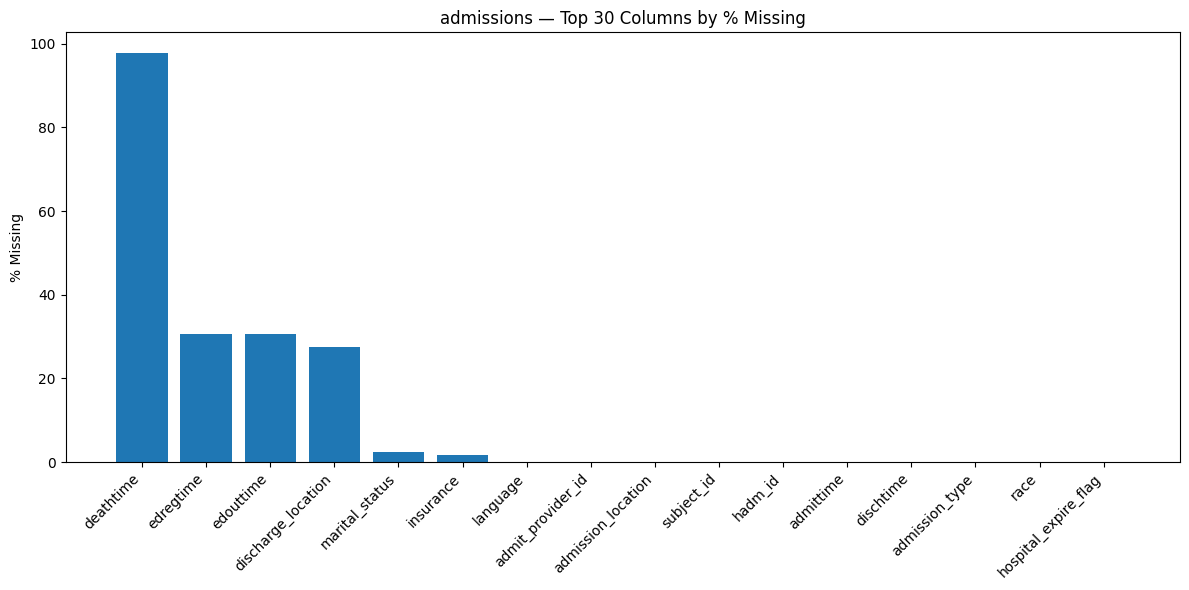

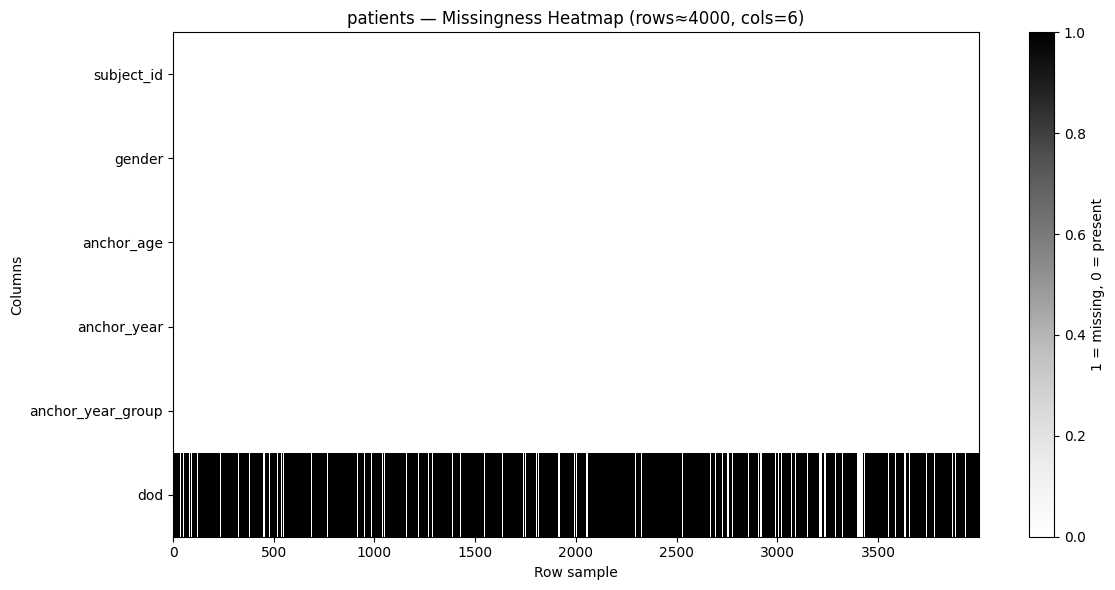

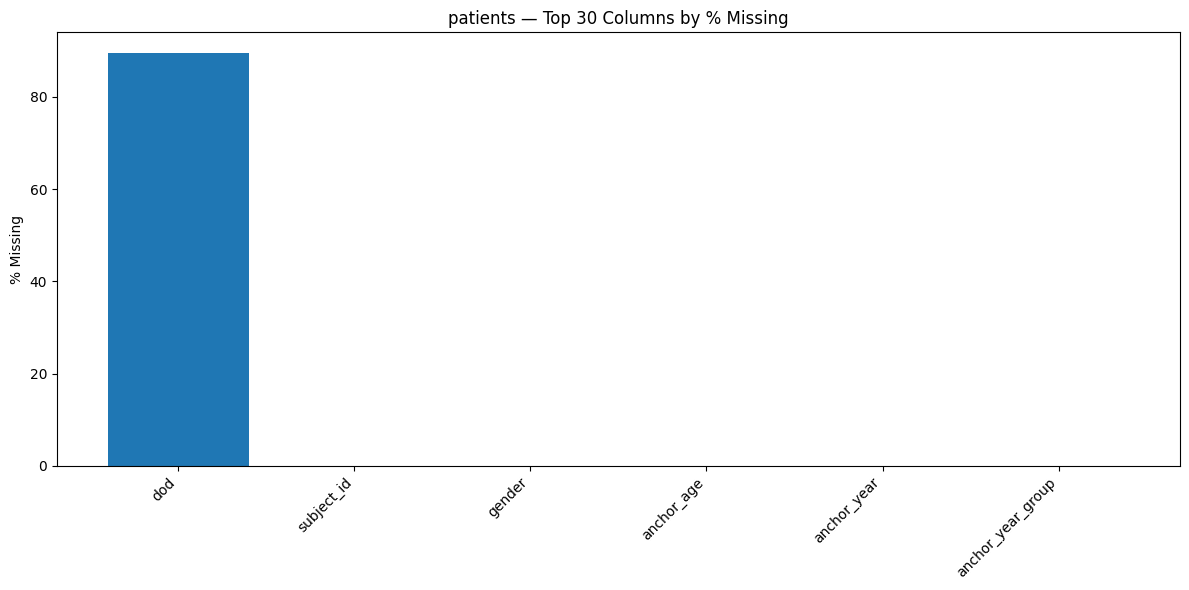

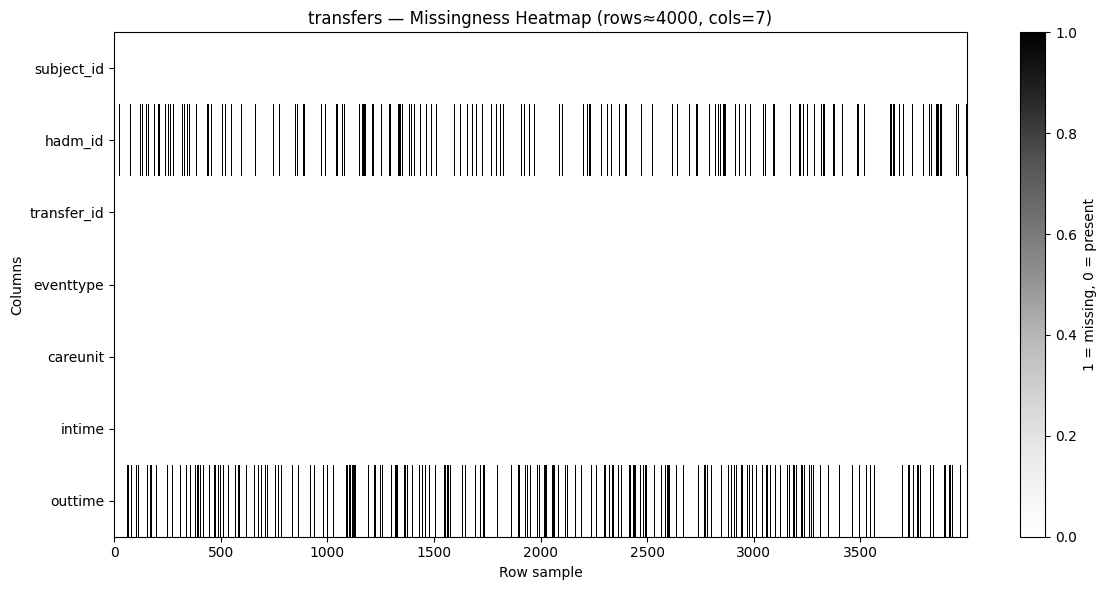

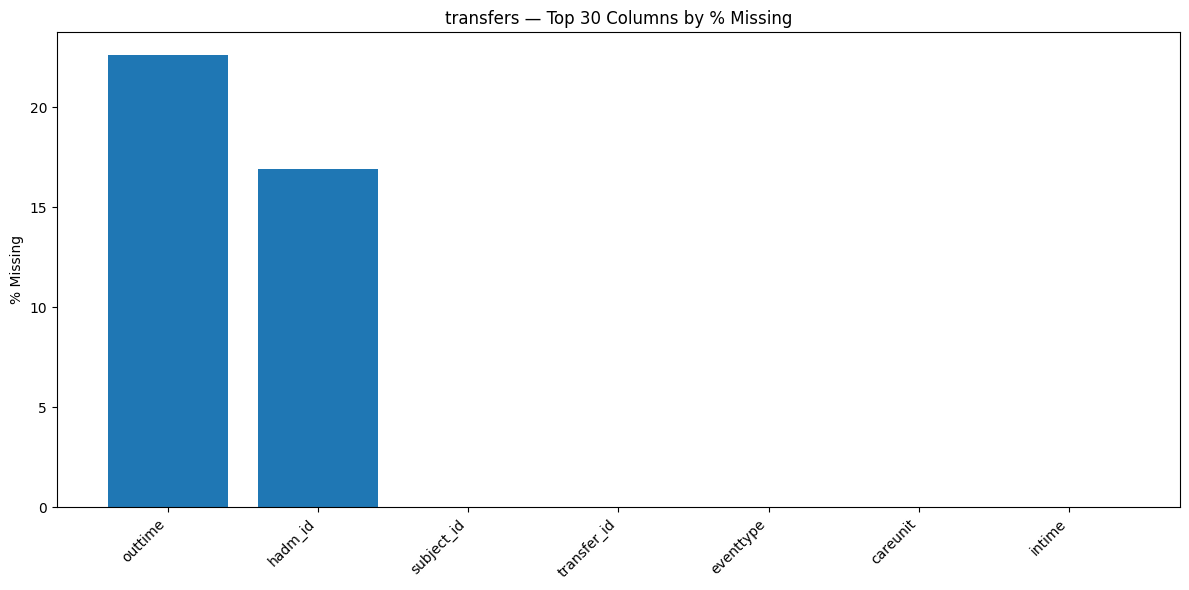

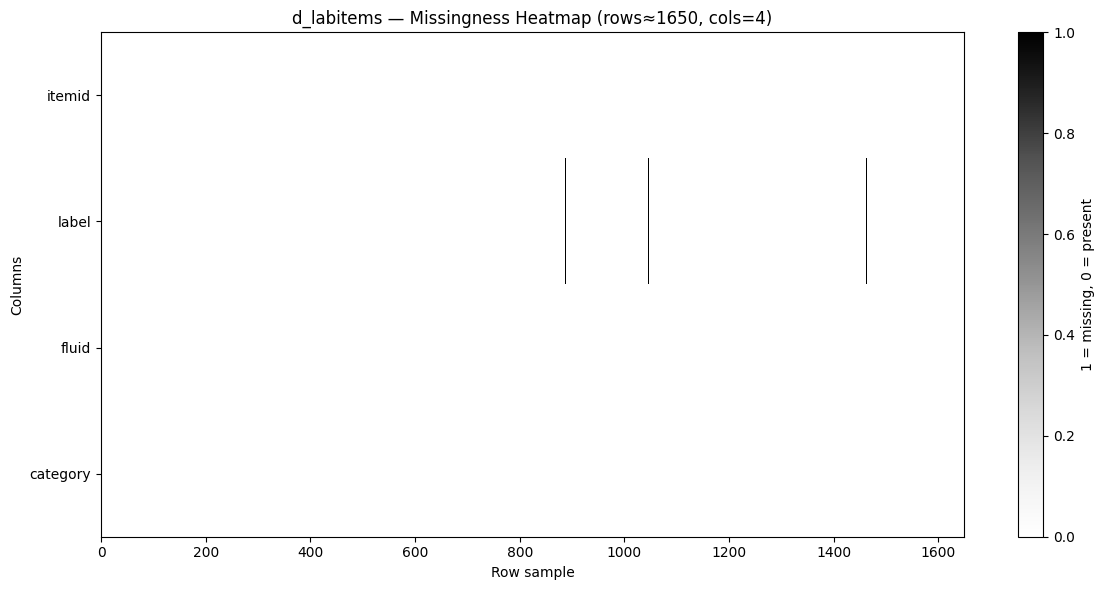

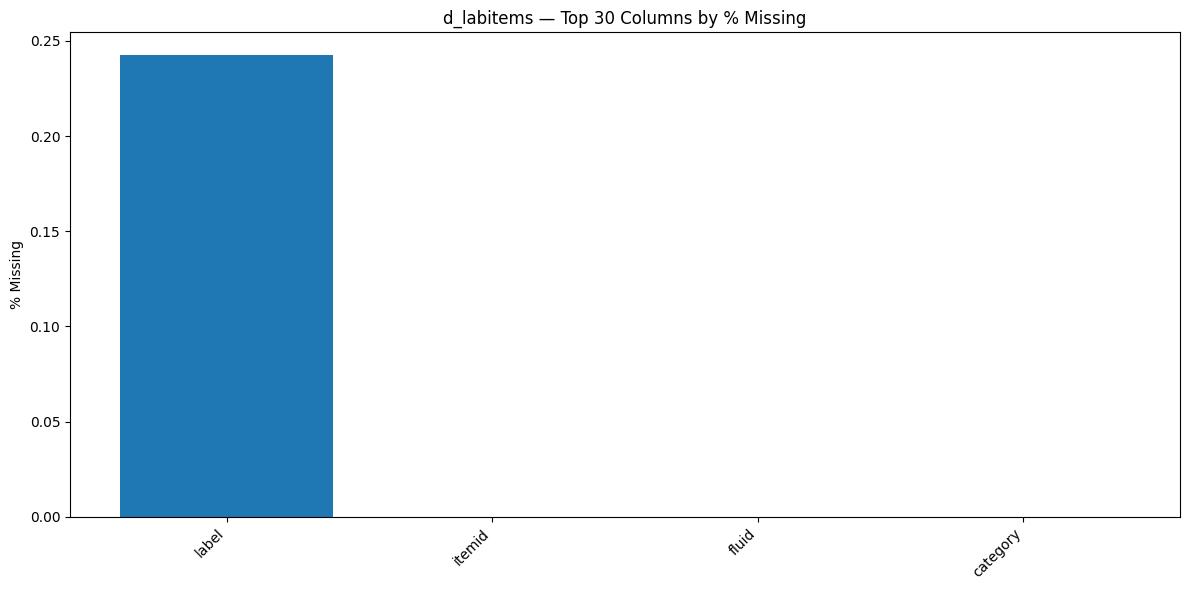

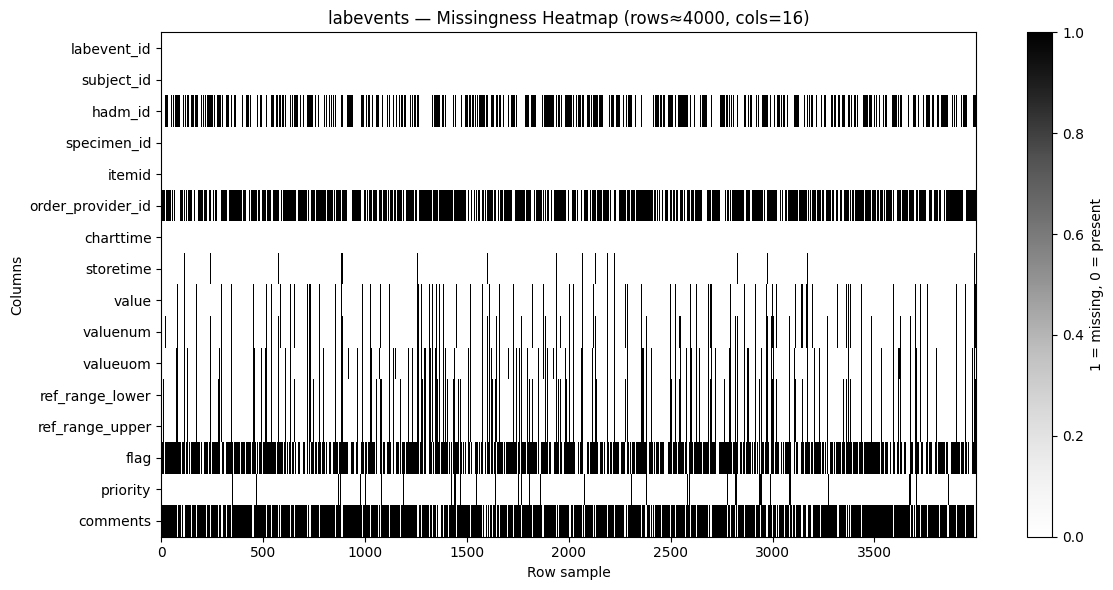

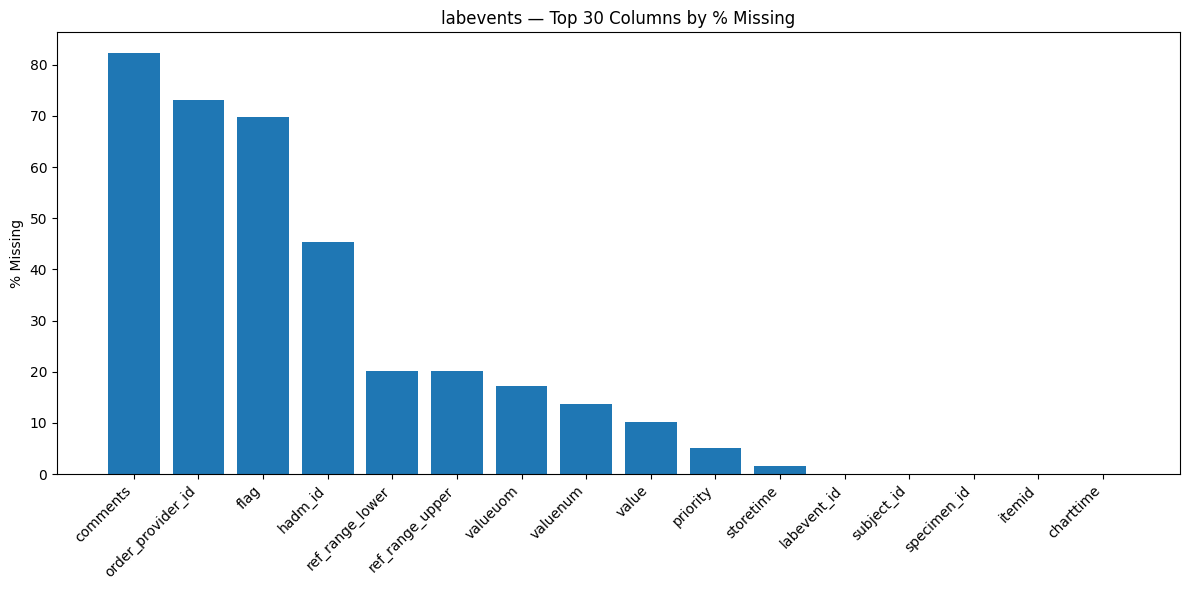

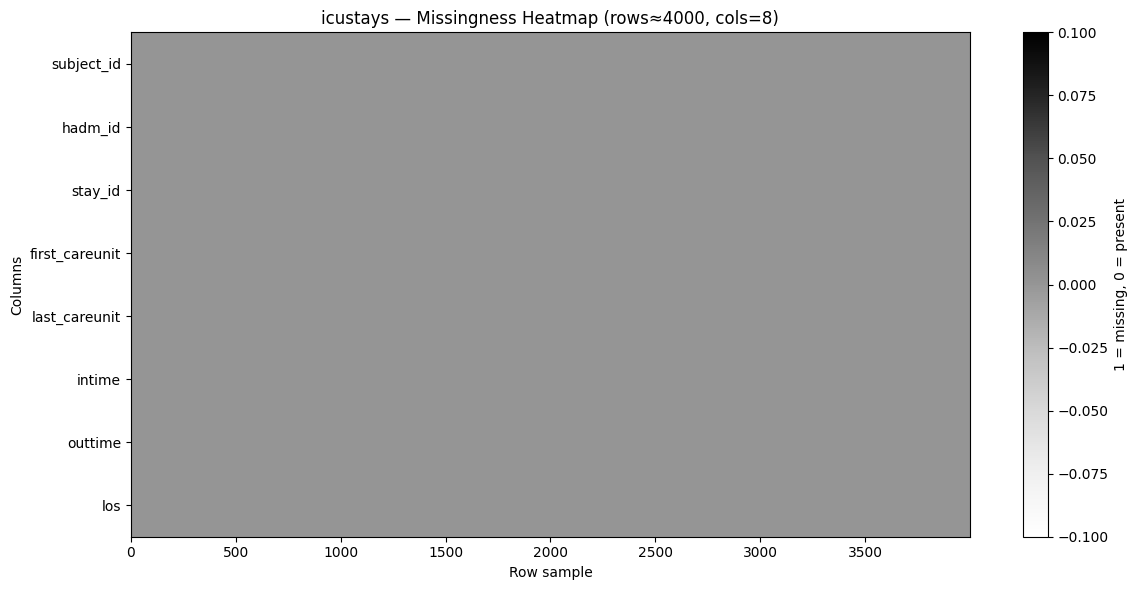

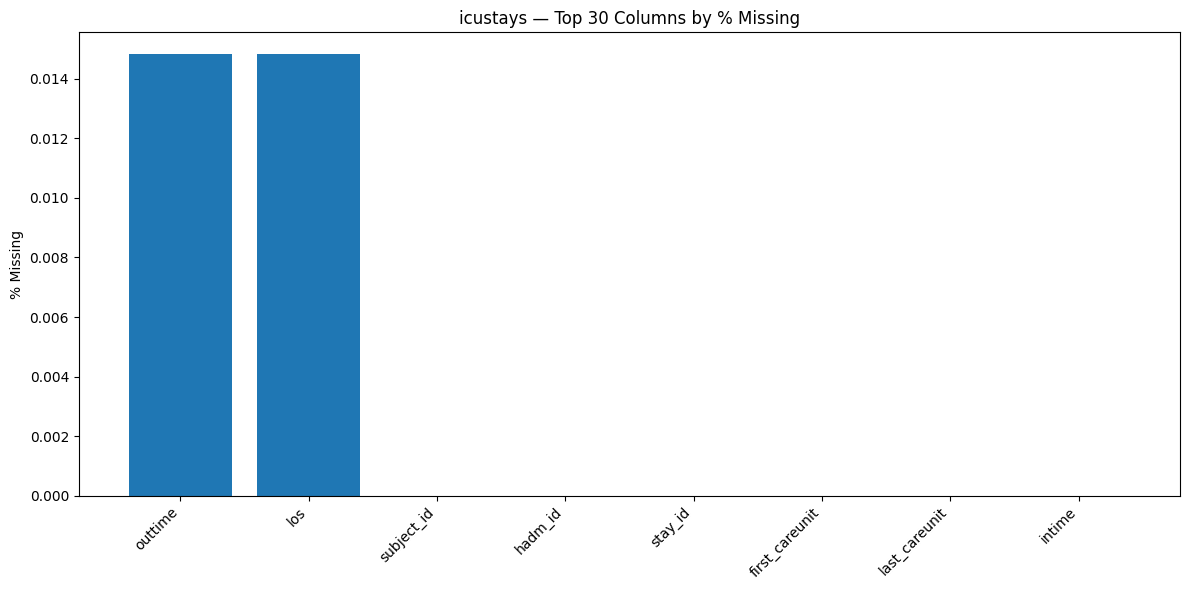

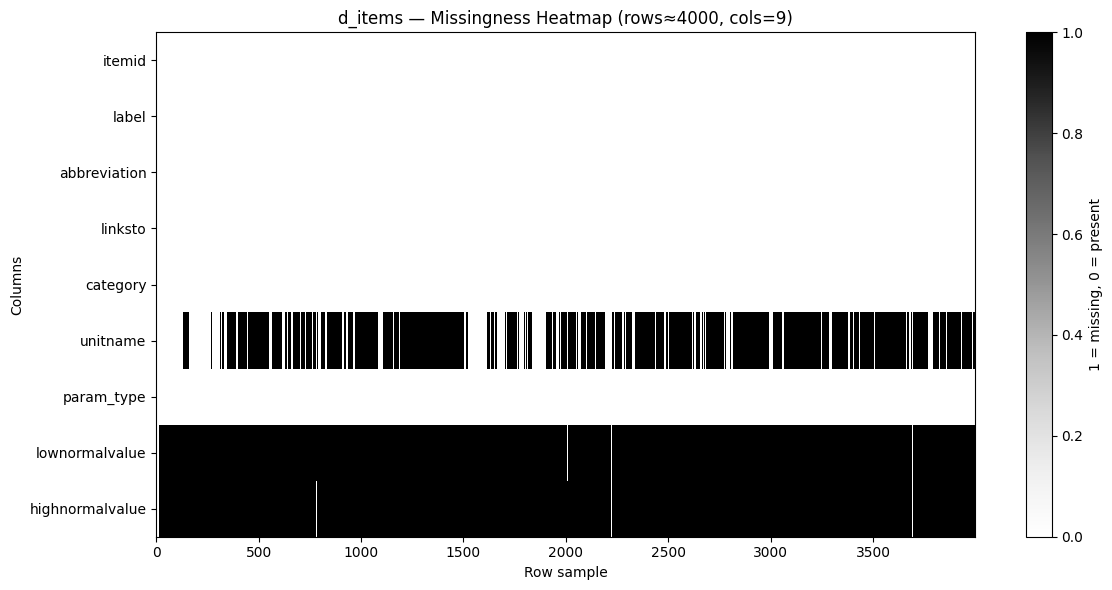

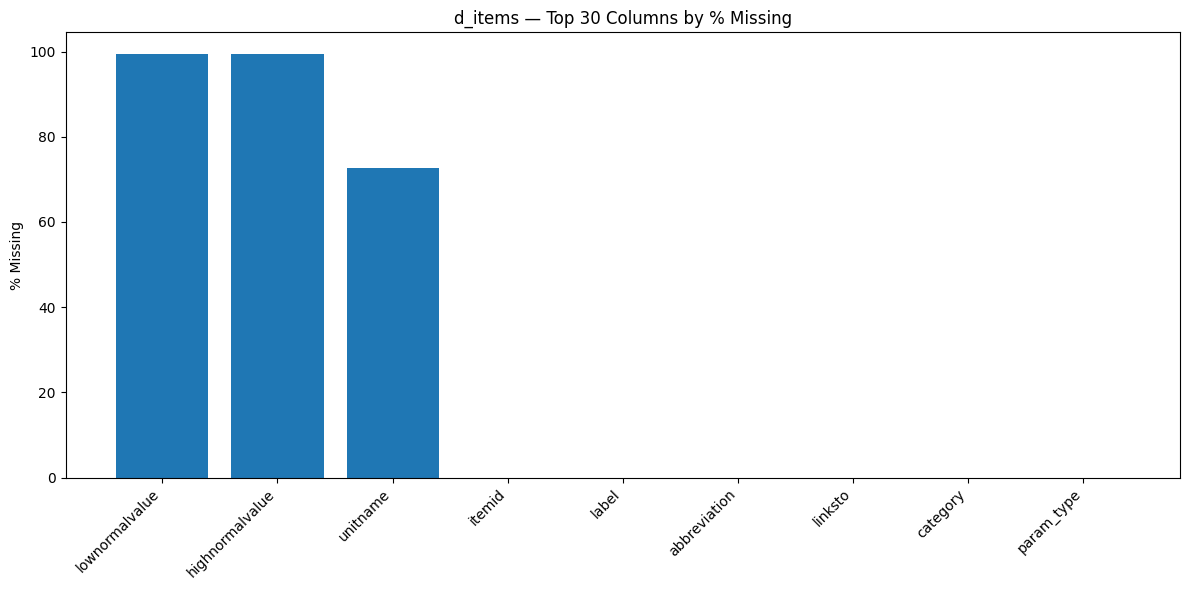

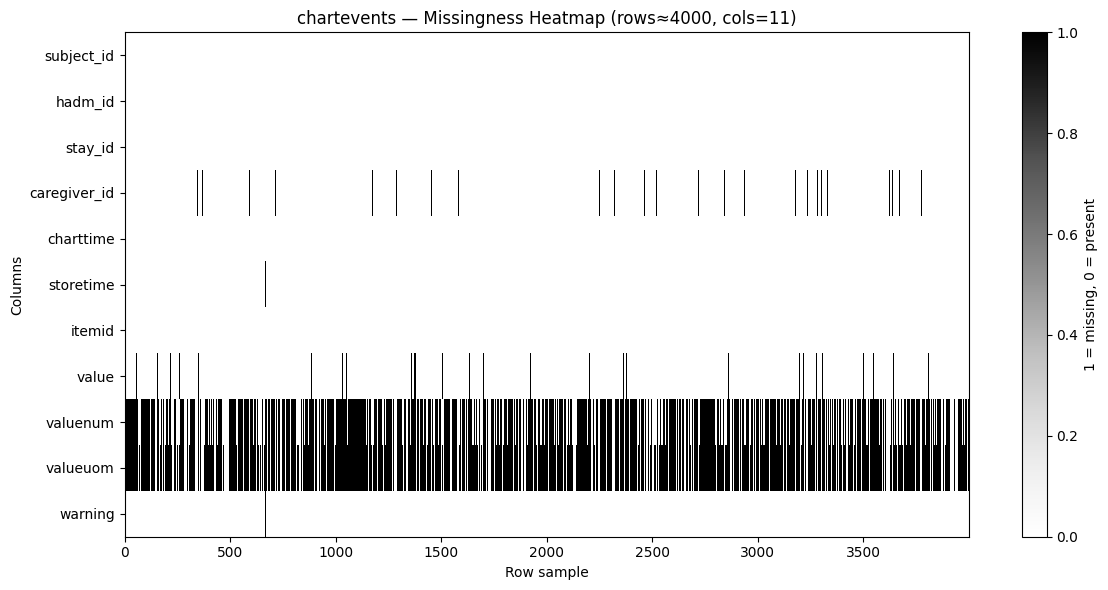

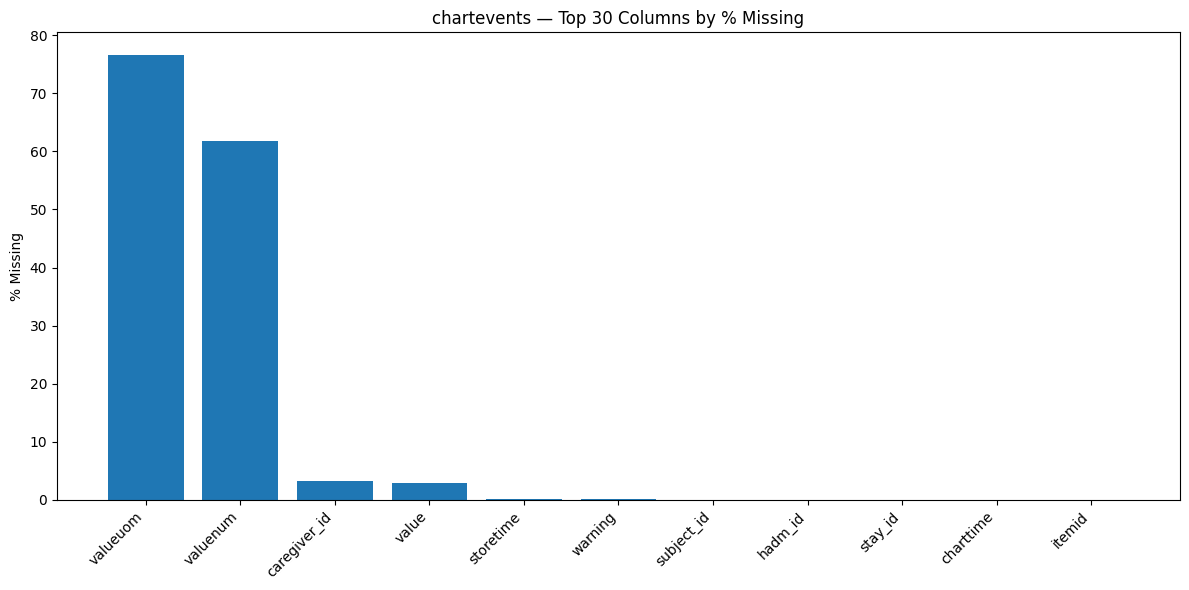

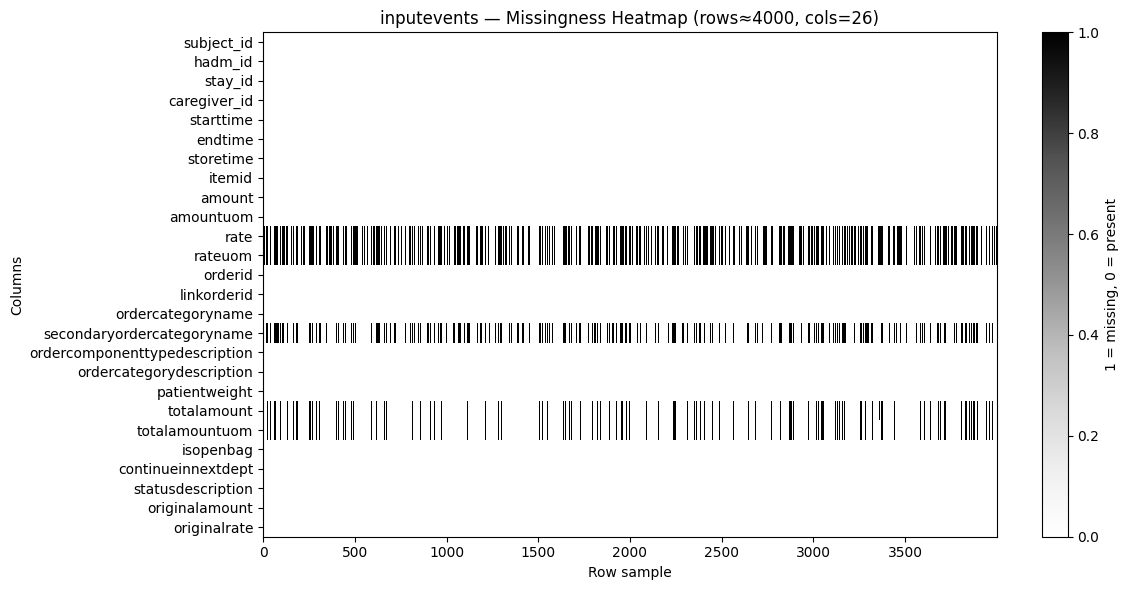

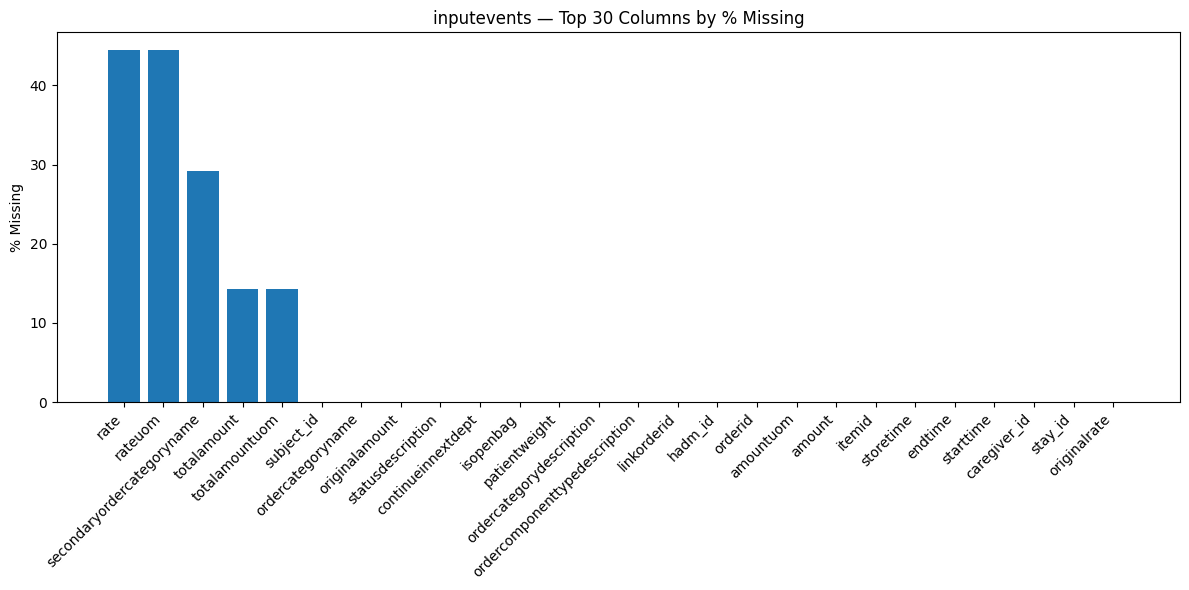

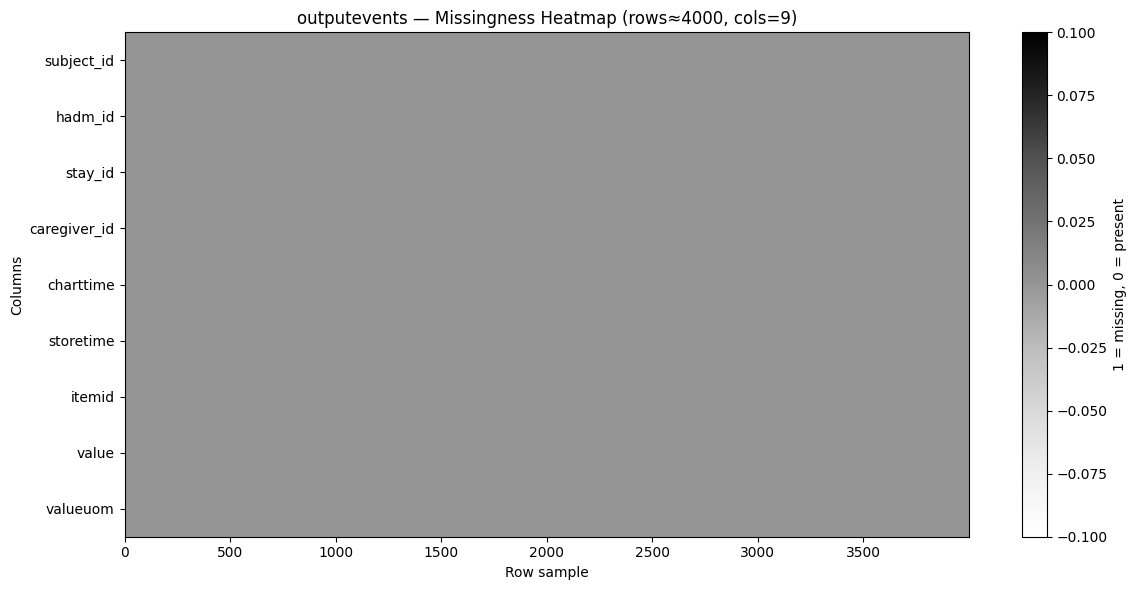

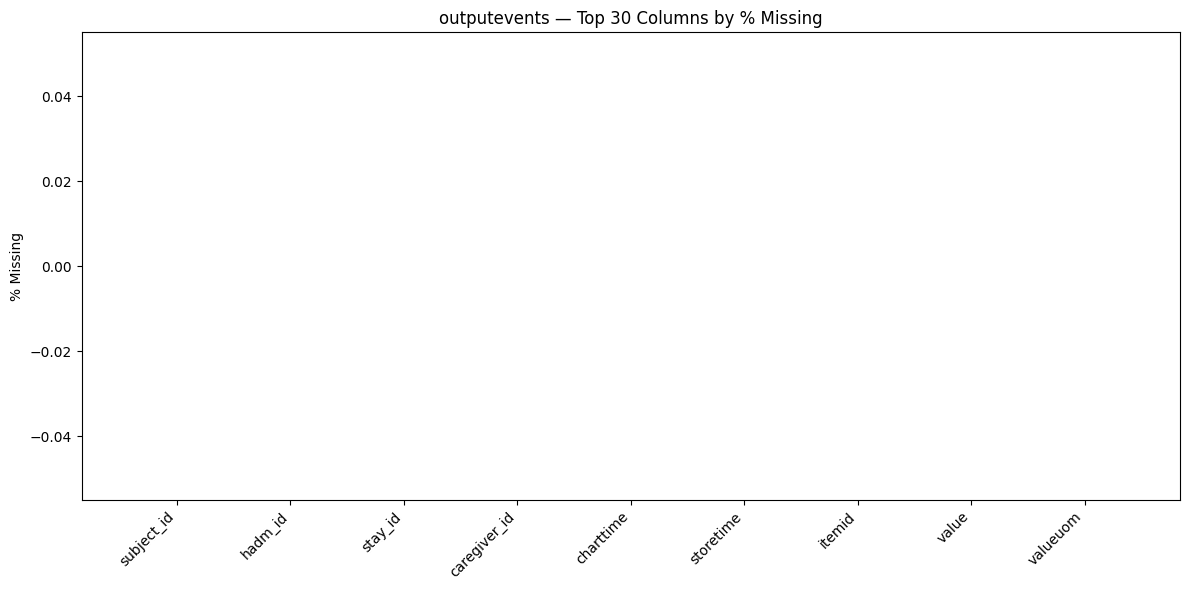

In [439]:
# HOSP
plot_missing_heatmap(admissions, "admissions")
plot_missing_bar(admissions, "admissions")

plot_missing_heatmap(patients, "patients")
plot_missing_bar(patients, "patients")

plot_missing_heatmap(transfers, "transfers")
plot_missing_bar(transfers, "transfers")

plot_missing_heatmap(d_labitems, "d_labitems")   # dictionary; usually very complete
plot_missing_bar(d_labitems, "d_labitems")

plot_missing_heatmap(labevents, "labevents")     # large; sampled
plot_missing_bar(labevents, "labevents", top_n=30)

# ICU
plot_missing_heatmap(icustays, "icustays")
plot_missing_bar(icustays, "icustays")

plot_missing_heatmap(d_items, "d_items")         # dictionary; usually very complete
plot_missing_bar(d_items, "d_items")

plot_missing_heatmap(chartevents, "chartevents") # very large; sampled
plot_missing_bar(chartevents, "chartevents", top_n=30)

plot_missing_heatmap(inputevents, "inputevents") # large; sampled
plot_missing_bar(inputevents, "inputevents", top_n=30)

plot_missing_heatmap(outputevents, "outputevents") # large; sampled
plot_missing_bar(outputevents, "outputevents", top_n=30)


In [440]:
## outlier detection

# for numeric columns
def iqr_outlier_cap(df, col):
    """Cap outliers in a numeric column using IQR method."""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping
    df[col] = np.where(df[col] < lower_bound, lower_bound,
                       np.where(df[col] > upper_bound, upper_bound, df[col]))
    return df

inputevents = iqr_outlier_cap(inputevents, 'amount')
inputevents = iqr_outlier_cap(inputevents, 'totalamount')
inputevents = iqr_outlier_cap(inputevents, 'originalamount')

inputevents.head()

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,amount,amountuom,...,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
0,10000032,29079034,39553978,18704,2180-07-23 17:00:00,2180-07-23 17:01:00,2180-07-23 18:56:00,226452,200.000000,mL,...,Main order parameter,Bolus,39.4,200.0,mL,0,0,FinishedRunning,200.0,200.0
1,10000032,29079034,39553978,18704,2180-07-23 17:00:00,2180-07-23 17:30:00,2180-07-23 17:02:00,220862,49.999999,mL,...,Main order parameter,Continuous IV,39.4,50.0,mL,0,0,FinishedRunning,50.0,100.0
2,10000032,29079034,39553978,18704,2180-07-23 17:33:00,2180-07-23 18:03:00,2180-07-23 18:16:00,220862,49.999999,mL,...,Main order parameter,Continuous IV,39.4,50.0,mL,0,0,FinishedRunning,50.0,100.0
3,10000032,29079034,39553978,18704,2180-07-23 18:56:00,2180-07-23 18:57:00,2180-07-23 18:56:00,226452,100.000000,mL,...,Main order parameter,Bolus,39.4,100.0,mL,0,0,FinishedRunning,100.0,100.0
4,10000032,29079034,39553978,20925,2180-07-23 21:10:00,2180-07-23 21:11:00,2180-07-23 21:10:00,226452,100.000000,mL,...,Main order parameter,Bolus,39.4,100.0,mL,0,0,FinishedRunning,100.0,100.0


In [441]:
# range filtering

def clinical_filter(df, col, min_val, max_val):
    """Remove physiologically implausible values."""
    return df[(df[col] >= min_val) & (df[col] <= max_val)]

chartevents = clinical_filter(chartevents, 'valuenum', 30, 250)

chartevents.head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
6,10000032,29079034,39553978,18704.0,2180-07-23 14:00:00,2180-07-23 14:20:00,223761,98.7,98.7,°F,0.0
7,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220179,84,84.0,mmHg,0.0
8,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220180,48,48.0,mmHg,0.0
9,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220181,56,56.0,mmHg,0.0
10,10000032,29079034,39553978,18704.0,2180-07-23 14:12:00,2180-07-23 14:17:00,220045,91,91.0,bpm,0.0


In [442]:
labevetns = clinical_filter(labevents,'valuenum', 30, 250)

labevetns.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,1,10000032,NaN,2704548,50931,P69FQC,2180-03-23 11:51:00,2180-03-23 15:56:00,___,95.0,mg/dL,70.0,100.0,NaN,ROUTINE,"IF FASTING, 70-100 NORMAL, >125 PROVISIONAL DI..."
10,11,10000032,NaN,83925500,50861,P69FQC,2180-03-23 11:51:00,2180-03-23 16:40:00,102,102.0,IU/L,0.0,40.0,abnormal,ROUTINE,NaN
12,13,10000032,NaN,83925500,50863,P69FQC,2180-03-23 11:51:00,2180-03-23 16:40:00,109,109.0,IU/L,35.0,105.0,abnormal,ROUTINE,NaN
15,16,10000032,NaN,83925500,50878,P69FQC,2180-03-23 11:51:00,2180-03-23 16:40:00,143,143.0,IU/L,0.0,40.0,abnormal,ROUTINE,NaN
20,21,10000032,NaN,83925500,50902,P69FQC,2180-03-23 11:51:00,2180-03-23 16:40:00,101,101.0,mEq/L,96.0,108.0,NaN,ROUTINE,NaN


In [443]:
# Example: filter out Calculated Total CO2 values (itemid=50804 in MIMIC)
CO2_id = 50804  # example ID for glucose
CO2_df = labevents[labevents['itemid'] == CO2_id].copy()

CO2_df = CO2_df[
    (CO2_df['valuenum'] >= 30) &
    (CO2_df['valuenum'] <= 1000)
]

CO2_df.head(10)

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
3828,3838,10000690,25860671.0,32183172,50804,NaN,2150-11-08 05:43:00,2150-11-08 05:46:00,37,37.0,mEq/L,21.0,30.0,abnormal,NaN,NaN
17047,17113,10001843,26133978.0,91199758,50804,NaN,2134-12-05 18:06:00,2134-12-05 18:31:00,30,30.0,mEq/L,21.0,30.0,NaN,NaN,NaN
17088,17154,10001843,26133978.0,44776621,50804,NaN,2134-12-05 19:30:00,2134-12-05 19:52:00,31,31.0,mEq/L,21.0,30.0,abnormal,NaN,NaN
19165,19233,10001884,29678536.0,16791588,50804,NaN,2130-10-10 09:31:00,2130-10-10 09:32:00,33,33.0,mEq/L,21.0,30.0,abnormal,NaN,NaN
19292,19360,10001884,NaN,93886749,50804,NaN,2130-10-19 13:58:00,2130-10-19 14:00:00,39,39.0,mEq/L,21.0,30.0,abnormal,NaN,NaN
19543,19611,10001884,28664981.0,45238768,50804,NaN,2130-11-29 00:15:00,2130-11-29 00:17:00,33,33.0,mEq/L,21.0,30.0,abnormal,NaN,NaN
19605,19674,10001884,NaN,67077372,50804,NaN,2130-12-06 17:54:00,2130-12-06 18:14:00,34,34.0,mEq/L,21.0,30.0,abnormal,NaN,NaN
19654,19723,10001884,NaN,78347223,50804,NaN,2130-12-23 15:58:00,2130-12-23 16:00:00,31,31.0,mEq/L,21.0,30.0,abnormal,NaN,NaN
20001,20072,10001884,26184834.0,24156928,50804,NaN,2131-01-10 13:15:00,2131-01-10 13:16:00,33,33.0,mEq/L,21.0,30.0,abnormal,NaN,NaN
20067,20138,10001884,26184834.0,11056293,50804,NaN,2131-01-11 01:51:00,2131-01-11 01:54:00,37,37.0,mEq/L,21.0,30.0,abnormal,NaN,NaN


In [444]:
d_labitems.head()
# itemid map to other datasets' itemid under hosp folder

,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas


In [445]:
chartevents

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
6,10000032,29079034,39553978,18704.0,2180-07-23 14:00:00,2180-07-23 14:20:00,223761,98.7,98.7,°F,0.0
7,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220179,84,84.0,mmHg,0.0
8,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220180,48,48.0,mmHg,0.0
9,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220181,56,56.0,mmHg,0.0
10,10000032,29079034,39553978,18704.0,2180-07-23 14:12:00,2180-07-23 14:17:00,220045,91,91.0,bpm,0.0
...,...,...,...,...,...,...,...,...,...,...,...
799977,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 19:58:00,220181,72,72.0,mmHg,0.0
799994,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 20:15:00,220045,98,98.0,bpm,0.0
799996,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 20:15:00,220050,71,71.0,mmHg,0.0
799997,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 20:15:00,220051,40,40.0,mmHg,0.0


In [446]:
chartevents1 = chartevents.merge(d_items[['itemid', 'label']], on='itemid', how='left')
vitals = chartevents1[chartevents1['label'].isin([
    'Heart Rate', 'Temperature Celsius', 'O2 saturation pulseoxymetry', 'Respiratory Rate',
    'Non Invasive Blood Pressure systolic', 'Non Invasive Blood Pressure diastolic', 'Non Invasive Blood Pressure mean'
])]


vitals

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label
1,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220179,84,84.0,mmHg,0.0,Non Invasive Blood Pressure systolic
2,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220180,48,48.0,mmHg,0.0,Non Invasive Blood Pressure diastolic
3,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220181,56,56.0,mmHg,0.0,Non Invasive Blood Pressure mean
4,10000032,29079034,39553978,18704.0,2180-07-23 14:12:00,2180-07-23 14:17:00,220045,91,91.0,bpm,0.0,Heart Rate
5,10000032,29079034,39553978,18704.0,2180-07-23 14:13:00,2180-07-23 14:17:00,220277,98,98.0,%,0.0,O2 saturation pulseoxymetry
...,...,...,...,...,...,...,...,...,...,...,...,...
122581,10017531,21095812,32136798,77991.0,2160-01-04 06:00:00,2160-01-04 06:10:00,220277,98,98.0,%,0.0,O2 saturation pulseoxymetry
122589,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 19:58:00,220179,111,111.0,mmHg,0.0,Non Invasive Blood Pressure systolic
122590,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 19:58:00,220180,62,62.0,mmHg,0.0,Non Invasive Blood Pressure diastolic
122591,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 19:58:00,220181,72,72.0,mmHg,0.0,Non Invasive Blood Pressure mean


In [447]:
vitals.loc[vitals['label'] == 'Respiratory Rate']

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label
247,10000690,25860671,37081114,33125.0,2150-11-03 12:00:00,2150-11-03 12:31:00,220210,30,30.0,insp/min,0.0,Respiratory Rate
315,10000690,25860671,37081114,33125.0,2150-11-05 12:00:00,2150-11-05 12:58:00,220210,32,32.0,insp/min,0.0,Respiratory Rate
570,10000690,25860671,37081114,85861.0,2150-11-05 11:45:00,2150-11-05 11:48:00,220210,33,33.0,insp/min,0.0,Respiratory Rate
579,10000690,25860671,37081114,97115.0,2150-11-03 19:00:00,2150-11-03 20:30:00,220210,35,35.0,insp/min,0.0,Respiratory Rate
1941,10001884,26184834,37510196,10437.0,2131-01-14 07:00:00,2131-01-14 08:06:00,220210,32,32.0,insp/min,0.0,Respiratory Rate
...,...,...,...,...,...,...,...,...,...,...,...,...
122253,10017531,21095812,32136798,68749.0,2160-01-29 09:00:00,2160-01-29 10:07:00,220210,33,33.0,insp/min,0.0,Respiratory Rate
122282,10017531,21095812,32136798,68749.0,2160-01-29 15:00:00,2160-01-29 17:37:00,220210,33,33.0,insp/min,0.0,Respiratory Rate
122291,10017531,21095812,32136798,68749.0,2160-01-29 17:00:00,2160-01-29 17:37:00,220210,33,33.0,insp/min,0.0,Respiratory Rate
122344,10017531,21095812,32136798,69078.0,2160-02-04 02:00:00,2160-02-04 04:24:00,220210,31,31.0,insp/min,0.0,Respiratory Rate


In [448]:
SYNONYMS = {
    # Heart rate
    "Heart Rate": "Heart Rate",
    "HR": "Heart Rate",

    # Temperature (Celsius only – you already filtered to Temperature Celsius)
    "Temperature Celsius": "Temperature Celsius",
    "Temperature (C)": "Temperature Celsius",

    # SpO2
    "SpO2": "SpO2",
    "O2 saturation pulseoxymetry": "SpO2",
    "O2 Saturation pulseoximetry": "SpO2",
    "Oxygen Saturation": "SpO2",

    # Respiratory Rate
    "Respiratory Rate": "Respiratory Rate",
    "Resp Rate": "Respiratory Rate",

    # Non-invasive BP
    "Systolic BP": "Systolic BP",
    "Non Invasive Blood Pressure systolic": "Systolic BP",
    "NIBP systolic": "Systolic BP",

    "Diastolic BP": "Diastolic BP",
    "Non Invasive Blood Pressure diastolic": "Diastolic BP",
    "NIBP diastolic": "Diastolic BP",

    "Mean BP": "Mean BP",
    "Non Invasive Blood Pressure mean": "Mean BP",
    "NIBP mean": "Mean BP",
}

# Apply mapping (keep only rows that we can standardize)
v = vitals.copy()
v["std_label"] = v["label"].map(SYNONYMS)
v = v[v["std_label"].notna()].copy()

In [449]:
PHYS_RANGE = {
    "Heart Rate": (20, 250),
    "Temperature Celsius": (30, 43),
    "SpO2": (50, 100),
    "Respiratory Rate": (5, 60),
    "Systolic BP": (50, 250),
    "Diastolic BP": (30, 150),
    "Mean BP": (40, 200),
}

v = v[pd.to_numeric(v["valuenum"], errors="coerce").notnull()].copy()
v["valuenum"] = v["valuenum"].astype(float)

rm = 0
for lbl, (lo, hi) in PHYS_RANGE.items():
    bad = (v["std_label"].eq(lbl)) & ~v["valuenum"].between(lo, hi)
    rm += bad.sum()
    v = v[~bad]
print(f"Removed {rm:,} physiologic outliers")

Removed 38 physiologic outliers


In [450]:
summary_rows = []

for lbl, (lo, hi) in PHYS_RANGE.items():
    subset = v[v["std_label"] == lbl]
    n_total = len(subset)
    n_outlier = ((subset["valuenum"] < lo) | (subset["valuenum"] > hi)).sum()
    outlier_pct = (n_outlier / n_total * 100) if n_total > 0 else 0

    summary_rows.append({
        "Vital Sign": lbl,
        "Lower Bound": lo,
        "Upper Bound": hi,
        "N (Total)": n_total,
        "Outliers (Count)": n_outlier,
        "Outliers (%)": round(outlier_pct, 2)
    })

range_summary = pd.DataFrame(summary_rows)

# --- Display result ---
print("\nPhysiologic Range Outlier Summary:")
display(range_summary)

# --- Optionally print total removed ---
total_removed = range_summary["Outliers (Count)"].sum()
print(f"\nTotal physiologic outliers removed: {int(total_removed)}")


Physiologic Range Outlier Summary:


,Vital Sign,Lower Bound,Upper Bound,N (Total),Outliers (Count),Outliers (%)
0,Heart Rate,20,250,16274,0,0.0
1,Temperature Celsius,30,43,668,0,0.0
2,SpO2,50,100,15901,0,0.0
3,Respiratory Rate,5,60,513,0,0.0
4,Systolic BP,50,250,11151,0,0.0
5,Diastolic BP,30,150,11105,0,0.0
6,Mean BP,40,200,11126,0,0.0



Total physiologic outliers removed: 0


In [451]:
v["charttime"] = pd.to_datetime(v["charttime"], errors="coerce")
v["hour"] = v["charttime"].dt.floor("H")

v_wide = (
    v.pivot_table(index=["stay_id", "hour"],
                  columns="std_label", values="valuenum", aggfunc="mean")
     .reset_index()
)

/var/folders/50/kl1nz0js0wz17qy0wjk9v11c0000gn/T/ipykernel_7055/720552550.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  v["hour"] = v["charttime"].dt.floor("H")


In [452]:
# Make sure sorting is correct
v = v.sort_values(["stay_id", "std_label", "charttime"]).reset_index(drop=True)

# Parameters
ROLL_WINDOW = 6        # ~6 hours if hourly
MIN_PERIODS = 3        # need at least 3 points to trust mean/std
Z_THRESH = 3.5         # can try 3.0–4.0

def add_rolling_z(group):
    """
    group: all rows for one (stay_id, std_label),
    sorted by charttime.
    """
    x = group["valuenum"]

    roll_mean = x.rolling(window=ROLL_WINDOW, min_periods=MIN_PERIODS).mean()
    roll_std  = x.rolling(window=ROLL_WINDOW, min_periods=MIN_PERIODS).std()

    # avoid division by zero
    z = (x - roll_mean) / roll_std
    z = z.replace([np.inf, -np.inf], np.nan)

    group["z_score"] = z
    return group

# Apply per stay + vital
v = (
    v.groupby(["stay_id", "std_label"], group_keys=False)
     .apply(add_rolling_z)
)

# Flag rolling-z outliers:
#  - have a defined z-score
#  - and |z| > threshold
z_outlier = v["z_score"].abs() > Z_THRESH

removed_rolling = z_outlier.sum()
print(f"Removed {removed_rolling:,} time-series (rolling-z) outliers")

# Drop them
v_clean = v[~z_outlier].copy()


Removed 0 time-series (rolling-z) outliers


/var/folders/50/kl1nz0js0wz17qy0wjk9v11c0000gn/T/ipykernel_7055/1011071084.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_rolling_z)


In [453]:
# corr = v_wide[present].corr(method="pearson")

# plt.figure(figsize=(8,6))
# sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f",
#             linewidths=0.5, cbar_kws={'label': 'Pearson r'})
# plt.title("Correlation Heatmap of ICU Vital Signs", fontsize=14)
# plt.tight_layout()
# plt.show()

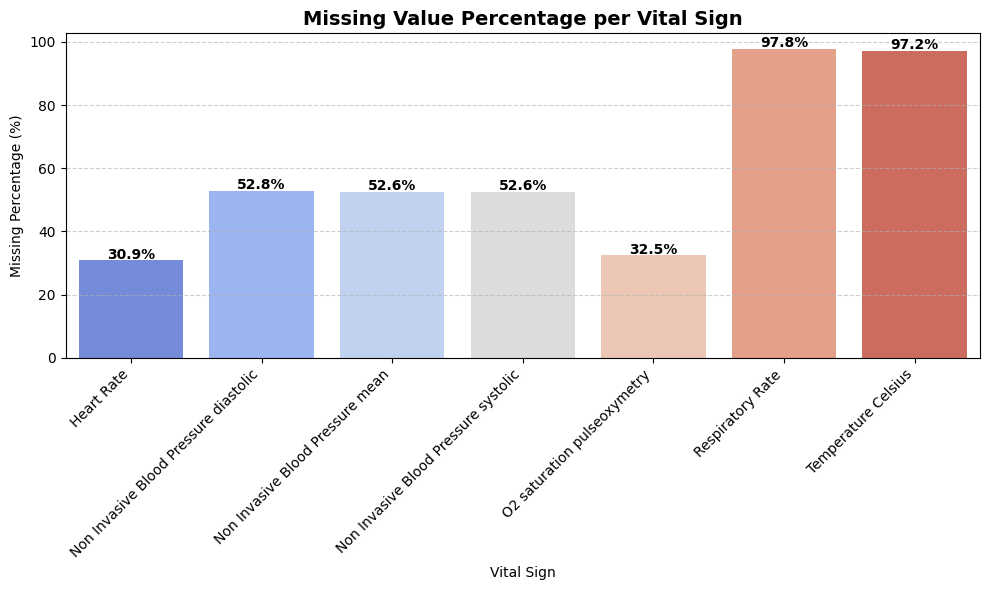

In [454]:
# --- 1. Select only the vital signs of interest ---
vital_labels = [
    'Heart Rate',
    'Temperature Celsius',
    'O2 saturation pulseoxymetry',
    'Respiratory Rate',
    'Non Invasive Blood Pressure systolic',
    'Non Invasive Blood Pressure diastolic',
    'Non Invasive Blood Pressure mean'
]

vitals = chartevents1[chartevents1['label'].isin(vital_labels)].copy()

# --- 2. Pivot to wide format ---
vitals_wide = vitals.pivot_table(
    index=['subject_id', 'charttime'],
    columns='label',
    values='valuenum',
    aggfunc='mean'
)

# --- 3. Compute missing-value percentages ---
missing_perc = vitals_wide.isnull().mean() * 100
missing_df = missing_perc.reset_index()
missing_df.columns = ['Vital Sign', 'Missing Percentage']

# --- 4. Plot histogram ---
plt.figure(figsize=(10,6))
sns.barplot(data=missing_df, x='Vital Sign', y='Missing Percentage', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title("Missing Value Percentage per Vital Sign", fontsize=14, weight='bold')
plt.ylabel("Missing Percentage (%)")
plt.xlabel("Vital Sign")

# Annotate values on bars
for i, v in enumerate(missing_df['Missing Percentage']):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [455]:
chartevents1

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label
0,10000032,29079034,39553978,18704.0,2180-07-23 14:00:00,2180-07-23 14:20:00,223761,98.7,98.7,°F,0.0,Temperature Fahrenheit
1,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220179,84,84.0,mmHg,0.0,Non Invasive Blood Pressure systolic
2,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220180,48,48.0,mmHg,0.0,Non Invasive Blood Pressure diastolic
3,10000032,29079034,39553978,18704.0,2180-07-23 14:11:00,2180-07-23 14:17:00,220181,56,56.0,mmHg,0.0,Non Invasive Blood Pressure mean
4,10000032,29079034,39553978,18704.0,2180-07-23 14:12:00,2180-07-23 14:17:00,220045,91,91.0,bpm,0.0,Heart Rate
...,...,...,...,...,...,...,...,...,...,...,...,...
122591,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 19:58:00,220181,72,72.0,mmHg,0.0,Non Invasive Blood Pressure mean
122592,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 20:15:00,220045,98,98.0,bpm,0.0,Heart Rate
122593,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 20:15:00,220050,71,71.0,mmHg,0.0,Arterial Blood Pressure systolic
122594,10017531,21095812,32136798,77991.0,2160-01-10 20:00:00,2160-01-10 20:15:00,220051,40,40.0,mmHg,0.0,Arterial Blood Pressure diastolic


In [456]:
vitals_imputed = vitals_wide.fillna(method='ffill').fillna(method='bfill')

summary_stats = vitals_imputed.agg(['mean', 'std', 'min', 'max']).T
summary_stats = summary_stats.rename(columns={
    'mean': 'Mean',
    'std': 'SD',
    'min': 'Min',
    'max': 'Max'
})
summary_stats = summary_stats.round(2)

print("Feature Summary (after missing-value imputation):")
display(summary_stats)

Feature Summary (after missing-value imputation):


/var/folders/50/kl1nz0js0wz17qy0wjk9v11c0000gn/T/ipykernel_7055/437145410.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vitals_imputed = vitals_wide.fillna(method='ffill').fillna(method='bfill')


,Mean,SD,Min,Max
label,,,,
Heart Rate,85.29,19.44,35.0,193.0
Non Invasive Blood Pressure diastolic,61.80,15.66,30.0,162.0
Non Invasive Blood Pressure mean,75.50,15.85,30.0,171.0
Non Invasive Blood Pressure systolic,115.86,22.00,46.0,232.0
O2 saturation pulseoxymetry,96.41,3.26,43.0,100.0
Respiratory Rate,32.51,3.33,30.0,56.0
Temperature Celsius,37.38,0.96,31.3,39.9


In [457]:
# Key vital itemids (adjust if needed)
HR_IDS  = [220045]  # Heart Rate
MAP_IDS = [220181, 220180, 220179]  # Non-Invasive or Arterial MAP
SPO2_IDS = [220277]  # O2 saturation pulseoxymetry
TEMP_IDS = [223762]  # Temperature C/F   223761, 
RESP_IDS = [220210]  # Respiratory rate , 224688

vitals = chartevents[chartevents["itemid"].isin(HR_IDS + MAP_IDS + SPO2_IDS + TEMP_IDS + RESP_IDS)]
vitals = vitals[["stay_id", "charttime", "itemid", "valuenum"]]


In [458]:
# Round to hourly timestamps for uniformity
vitals["charttime"] = pd.to_datetime(vitals["charttime"])
vitals["chart_hour"] = vitals["charttime"].dt.floor("H")

# Map itemid → vital name
id_to_label = {
    220045: "HR",
    220181: "MAP",
    220180: "MAP",
    220179: "MAP",
    220277: "SpO2",
    223761: "Temp",
    223762: "Temp",
    220210: "RespRate",
    224688: "RespRate"
}
vitals["label"] = vitals["itemid"].map(id_to_label)

# Aggregate (mean if multiple values per hour)
agg = (
    vitals.groupby(["stay_id", "chart_hour", "label"])["valuenum"]
    .mean()
    .unstack()
    .reset_index()
)


/var/folders/50/kl1nz0js0wz17qy0wjk9v11c0000gn/T/ipykernel_7055/1143848770.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  vitals["chart_hour"] = vitals["charttime"].dt.floor("H")


In [459]:
# Merge with demographics
merged = (
    agg.merge(icustays[["stay_id", "subject_id", "intime", "outtime", "los"]],
              on="stay_id", how="left")
        .merge(patients[["subject_id", "gender", "anchor_age"]],
              on="subject_id", how="left")
)

# Rename columns
merged = merged.rename(columns={"anchor_age": "Age", "gender": "Gender", "chart_hour": "charttime"})

# Add time since ICU admission
merged["charttime"] = pd.to_datetime(merged["charttime"])
merged["intime"] = pd.to_datetime(merged["intime"])

merged["hours_from_admit"] = (
    merged["charttime"] - merged["intime"]
).dt.total_seconds() / 3600


In [460]:
# Sort chronologically for each stay
merged = merged.sort_values(["stay_id", "charttime"]).reset_index(drop=True)

# --- Regression target: next-hour MAP ---
merged["MAP_next1h"] = merged.groupby("stay_id")["MAP"].shift(-1)

# --- Classification target: composite deterioration (next 6 hours) ---
def make_deterioration_flag_simple(df, horizon=6):
    df = df.sort_values("charttime").reset_index(drop=True).copy()
    v = df[["MAP", "SpO2", "HR", "RespRate", "Temp"]].copy()

    # 1) Physiologic clipping (optional but recommended)
    v["MAP"]      = v["MAP"].clip(30, 200)
    v["SpO2"]     = v["SpO2"].clip(50, 100)
    v["HR"]       = v["HR"].clip(30, 220)
    v["RespRate"] = v["RespRate"].clip(5, 50)
    v["Temp"]     = v["Temp"].clip(30, 43)

    # 2) ONLY forward fill, NO backward fill (to avoid using future info)
    v = v.ffill(limit=2)   #remove `.bfill(limit=1)` here

    # 3) Define danger NOW at each row
    danger_now = (
        (v["MAP"] < 65) |
        (v["SpO2"] < 92) |
        (v["HR"] > 110) |
        (v["HR"] < 50) |
        ((v["RespRate"] > 24) & v["RespRate"].notna()) |
        ((v["RespRate"] < 10) & v["RespRate"].notna()) |
        ((v["Temp"] >= 38.0) & v["Temp"].notna()) |
        ((v["Temp"] <= 36.0) & v["Temp"].notna())
    )

    future_danger = np.zeros(len(df), dtype=int)

    # 4) For each time i, look at the NEXT `horizon` rows (i+1 ... i+horizon)
    for i in range(len(df)):
        start = i + 1
        end   = min(i + horizon, len(df) - 1)
        if start <= end and danger_now.iloc[start:end+1].any():
            future_danger[i] = 1
        else:
            future_danger[i] = 0

    df["Deterioration_next6h"] = future_danger
    return df



# Apply per stay_id
merged = (
    merged.sort_values(["stay_id", "charttime"])
          .groupby("stay_id", group_keys=False)
          .apply(make_deterioration_flag_simple, horizon=6)
)

print(merged[["charttime", "MAP", "HR", "SpO2", "RespRate", "Temp", "Deterioration_next6h"]].head(15))


             charttime         MAP    HR  SpO2  RespRate  Temp  \
0  2137-10-21 18:00:00  115.000000  63.0  95.0       NaN   NaN   
1  2137-10-21 19:00:00  115.000000  63.0  93.0       NaN   NaN   
2  2137-10-21 20:00:00  102.333333  65.0  91.0       NaN   NaN   
3  2137-10-21 21:00:00  117.333333  60.0  99.0       NaN   NaN   
4  2137-10-21 22:00:00  101.666667  70.0  98.0       NaN   NaN   
5  2137-10-21 23:00:00   99.000000  69.0  95.0       NaN   NaN   
6  2137-10-22 00:00:00   98.666667  60.0  95.0       NaN   NaN   
7  2137-10-22 01:00:00   91.666667  60.0  98.0       NaN   NaN   
8  2137-10-22 02:00:00   92.666667  65.0  96.0       NaN   NaN   
9  2137-10-22 03:00:00   96.333333  71.0  95.0       NaN   NaN   
10 2137-10-22 04:00:00   74.000000  60.0  97.0       NaN   NaN   
11 2137-10-22 05:00:00  110.666667  69.0  98.0       NaN   NaN   
12 2137-10-22 06:00:00   69.333333  62.0  99.0       NaN   NaN   
13 2137-10-22 07:00:00  100.666667  66.0  98.0       NaN   NaN   
14 2137-10

/var/folders/50/kl1nz0js0wz17qy0wjk9v11c0000gn/T/ipykernel_7055/3203273914.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_deterioration_flag_simple, horizon=6)


In [461]:
#RF
merged_RF = merged.copy()

In [462]:
sid = 30072752

tmp = (
    merged[merged["stay_id"] == sid]
    .sort_values("charttime")
    .reset_index(drop=True)
)

# Recompute danger_now exactly as in the function
v = tmp[["MAP", "SpO2", "HR", "RespRate", "Temp"]].copy()
v = v.ffill(limit=2)

danger_now = (
    (v["MAP"] < 65) |
        (v["SpO2"] < 92) |
        (v["HR"] > 110) |
        (v["HR"] < 50) |
        (v["RespRate"] > 24) |
        (v["RespRate"] < 10) |
        (v["Temp"] >= 38.0) |
        (v["Temp"] <= 36.0)
)

tmp_debug = tmp.copy()
tmp_debug["danger_now"] = danger_now.astype(int)

print(
    tmp_debug[
        ["charttime", "MAP", "HR", "SpO2", "RespRate", "Temp", "danger_now", "Deterioration_next6h"]
    ].head(30)
)


             charttime         MAP    HR   SpO2  RespRate  Temp  danger_now  \
0  2137-10-21 18:00:00  115.000000  63.0   95.0       NaN   NaN           0   
1  2137-10-21 19:00:00  115.000000  63.0   93.0       NaN   NaN           0   
2  2137-10-21 20:00:00  102.333333  65.0   91.0       NaN   NaN           1   
3  2137-10-21 21:00:00  117.333333  60.0   99.0       NaN   NaN           0   
4  2137-10-21 22:00:00  101.666667  70.0   98.0       NaN   NaN           0   
5  2137-10-21 23:00:00   99.000000  69.0   95.0       NaN   NaN           0   
6  2137-10-22 00:00:00   98.666667  60.0   95.0       NaN   NaN           0   
7  2137-10-22 01:00:00   91.666667  60.0   98.0       NaN   NaN           0   
8  2137-10-22 02:00:00   92.666667  65.0   96.0       NaN   NaN           0   
9  2137-10-22 03:00:00   96.333333  71.0   95.0       NaN   NaN           0   
10 2137-10-22 04:00:00   74.000000  60.0   97.0       NaN   NaN           0   
11 2137-10-22 05:00:00  110.666667  69.0   98.0     

In [463]:
merged = merged.sort_values(["stay_id", "charttime"])
merged["MAP_next1h"] = merged.groupby("stay_id")["MAP"].shift(-1)

merged["Event_next6h"] = (
    merged.groupby("stay_id")["MAP"]
    .transform(lambda x: x.rolling(window=6, min_periods=1).min().shift(-1) < 65)
).astype(int)

In [464]:
# Drop rows with no vitals
merged = merged.dropna(subset=["HR", "MAP", "SpO2", "RespRate", "Temp"], how="all")

# Forward fill missing vitals per stay (within short gap)
merged[["HR", "MAP", "SpO2", "RespRate", "Temp"]] = (
    merged.groupby("stay_id")[["HR", "MAP", "SpO2", "RespRate", "Temp"]]
    .transform(lambda x: x.ffill(limit=2))
)

# Drop remaining NaNs if necessary
merged = merged.dropna(subset=["MAP_next1h", "Event_next6h"])


In [465]:
print(merged.head())


    stay_id           charttime    HR         MAP  RespRate  SpO2  Temp  \
0  30072752 2137-10-21 18:00:00  63.0  115.000000       NaN  95.0   NaN   
1  30072752 2137-10-21 19:00:00  63.0  115.000000       NaN  93.0   NaN   
2  30072752 2137-10-21 20:00:00  65.0  102.333333       NaN  91.0   NaN   
3  30072752 2137-10-21 21:00:00  60.0  117.333333       NaN  99.0   NaN   
4  30072752 2137-10-21 22:00:00  70.0  101.666667       NaN  98.0   NaN   

   subject_id              intime             outtime       los Gender  Age  \
0    10012789 2137-10-21 18:16:00 2137-10-27 14:28:42  5.842153      M   71   
1    10012789 2137-10-21 18:16:00 2137-10-27 14:28:42  5.842153      M   71   
2    10012789 2137-10-21 18:16:00 2137-10-27 14:28:42  5.842153      M   71   
3    10012789 2137-10-21 18:16:00 2137-10-27 14:28:42  5.842153      M   71   
4    10012789 2137-10-21 18:16:00 2137-10-27 14:28:42  5.842153      M   71   

   hours_from_admit  MAP_next1h  Deterioration_next6h  Event_next6h  
0   

In [466]:
cols = ["HR", "MAP", "RespRate", "SpO2", "Temp"]

# Forward-fill short gaps (up to 2 hours)
merged[cols] = (
    merged.groupby("stay_id", sort=False)[cols]
          .transform(lambda x: x.ffill(limit=2))
)

# 1) still OK to drop rows where *all* vitals are missing
merged = merged.dropna(subset=cols, how="all")

# 2) Add missingness indicators *before* ffill/median
for col in cols:
    merged[col + "_missing"] = merged[col].isna().astype(int)

# Fill remaining NaNs with the median for that stay
for c in cols:
    merged[c] = merged.groupby("stay_id")[c].transform(
        lambda x: x.fillna(x.median())
    )
    
global_medians = merged[cols].median()
merged[cols] = merged[cols].fillna(global_medians)

# If a stay has *all* missing vitals, drop it
merged = merged.dropna(subset=cols, how="all")


In [467]:
# --- Add lag features for vitals ---
lag_hours = [1, 2, 3]
vital_cols = ["HR", "MAP", "RespRate", "SpO2", "Temp"]

# make sure sorted
merged = merged.sort_values(["stay_id", "charttime"]).reset_index(drop=True)

for col in vital_cols:
    for h in lag_hours:
        lag_col = f"{col}_lag{h}"
        # shift within each stay_id to avoid leakage across patients
        merged[lag_col] = (
            merged.groupby("stay_id")[col].shift(h)
        )
        # for the first 1–3 hours where lag is NaN, fall back to current value
        merged[lag_col] = merged[lag_col].fillna(merged[col])


Lag features allow non-sequential models (like Random Forests) to see short-term trends, not just the current snapshot.

In [468]:
# === Add rolling min, max, mean for each vital ===
vital_cols = ["HR", "MAP", "SpO2", "RespRate", "Temp"]
window = 6  # e.g., 6-hour rolling summary per patient

# Sort for safe rolling operations
merged = merged.sort_values(["stay_id", "charttime"]).reset_index(drop=True)

for col in vital_cols:
    merged[f"{col}_mean{window}h"] = (
        merged.groupby("stay_id")[col]
        .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    )
    merged[f"{col}_min{window}h"] = (
        merged.groupby("stay_id")[col]
        .transform(lambda x: x.rolling(window=window, min_periods=1).min())
    )
    merged[f"{col}_max{window}h"] = (
        merged.groupby("stay_id")[col]
        .transform(lambda x: x.rolling(window=window, min_periods=1).max())
    )
    
missing_cols = [f"{v}_missing" for v in vital_cols]

In [469]:
# # Global Median Imputation

# merged['Temp'] = merged['Temp'].fillna(merged['Temp'].median())
# merged['RespRate'] = merged['RespRate'].fillna(merged['RespRate'].median())
# merged['Temp'] = merged['Temp'].fillna(merged['Temp'].median())
# merged['HR'] = merged['HR'].fillna(merged['HR'].median())
# merged['SpO2'] = merged['SpO2'].fillna(merged['SpO2'].median())
# merged['MAP'] = merged['MAP'].fillna(merged['MAP'].median())

In [470]:
merged.isna().sum()


stay_id                 0
charttime               0
HR                      0
MAP                     0
RespRate                0
SpO2                    0
Temp                    0
subject_id              0
intime                  0
outtime                 0
los                     0
Gender                  0
Age                     0
hours_from_admit        0
MAP_next1h              0
Deterioration_next6h    0
Event_next6h            0
HR_missing              0
MAP_missing             0
RespRate_missing        0
SpO2_missing            0
Temp_missing            0
HR_lag1                 0
HR_lag2                 0
HR_lag3                 0
MAP_lag1                0
MAP_lag2                0
MAP_lag3                0
RespRate_lag1           0
RespRate_lag2           0
RespRate_lag3           0
SpO2_lag1               0
SpO2_lag2               0
SpO2_lag3               0
Temp_lag1               0
Temp_lag2               0
Temp_lag3               0
HR_mean6h               0
HR_min6h    

In [471]:
missing_cols = [c + "_missing" for c in vital_cols]

window = 6

feature_cols = (
    vital_cols
    + [f"{v}_{stat}{window}h" for v in vital_cols for stat in ["mean", "min", "max"]]
    + ["Age", "hours_from_admit"]
    # + maybe the *_missing indicators if you added them
)


In [472]:
# # For classification
# X_cls = merged[["HR", "MAP", "SpO2", "RespRate", "Temp", "Age"]]
# y_cls = merged["Event_next6h"]

# # For regression
# X_reg = merged[["HR", "MAP", "SpO2", "RespRate", "Temp", "Age"]]
# y_reg = merged["MAP_next1h"]

X_cls = merged[feature_cols]
y_cls = merged["Deterioration_next6h"].astype(int)

X_reg = merged[feature_cols]
y_reg = merged["Deterioration_next6h"]


Logistic Regression evaluates risk detection: “how early can we warn?”

Random Forest Regressor evaluates trend accuracy: “how precisely can we predict the Deterioration_next6h”

ROC-AUC: 0.741

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.71      0.66       930
           1       0.73      0.64      0.68      1151

    accuracy                           0.67      2081
   macro avg       0.67      0.68      0.67      2081
weighted avg       0.68      0.67      0.67      2081

Confusion matrix:
[[656 274]
 [409 742]]

PR-AUC: 0.782


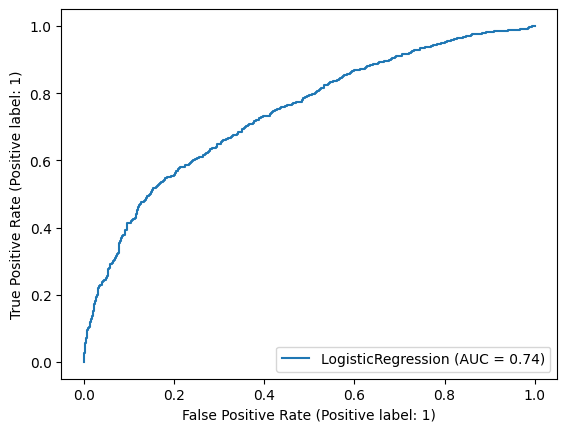

In [473]:
# logistic regression baseline model

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, stratify=y_cls, random_state=42
)

# Scale (logistic regression benefits from normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train baseline
lr = LogisticRegression(max_iter=500, class_weight='balanced', solver='lbfgs')
lr.fit(X_train_scaled, y_train)

# Predict
y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

# Metrics
roc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc:.3f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# PR-AUC
prec, rec, _ = precision_recall_curve(y_test, y_prob)
pr_auc = sk_auc(rec, prec)
print(f"\nPR-AUC: {pr_auc:.3f}")

# Optional ROC plot
RocCurveDisplay.from_estimator(lr, X_test_scaled, y_test)
plt.show()


=== Patient-level CV Summary (RF + Imputer) ===
Mean ROC-AUC: 0.694 ± 0.051
Mean PR-AUC:  0.719 ± 0.060


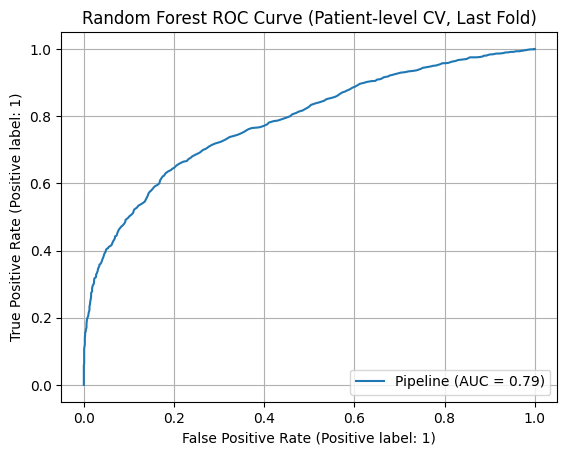

In [480]:
# Random Forest baseline model

label_col = "Deterioration_next6h"
vitals = ["HR", "MAP", "RespRate", "SpO2", "Temp"]

# ---- 1) Missingness indicators (create if not already present) ----
for c in vitals:
    mc = c + "_missing"
    if mc not in merged_RF.columns:
        merged_RF[mc] = merged_RF[c].isna().astype(int)

# ---- 2) Patient-level forward fill (more than 1 step; forward-only) ----
merged_RF[vitals] = (
    merged_RF
    .sort_values(["stay_id", "charttime"])
    .groupby("stay_id")[vitals]
    .ffill()
)

# ---- 3) Feature set: vitals + missing flags + demographics/time ----
feature_cols = vitals + ["Age", "hours_from_admit"] + [c + "_missing" for c in vitals]

X = merged_RF[feature_cols]
y = merged_RF[label_col].astype(int).values
groups = merged_RF["stay_id"].values

gkf = GroupKFold(n_splits=5)

# ---- 4) Model: impute within each CV fold (NO leakage) + RF ----
model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

cv_aucs, cv_prs = [], []
model_last, X_val_last, y_val_last = None, None, None

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_prob)
    prec, rec, _ = precision_recall_curve(y_val, y_prob)
    pr_auc = sk_auc(rec, prec)

    cv_aucs.append(roc_auc)
    cv_prs.append(pr_auc)

    # keep last fold for plotting
    model_last, X_val_last, y_val_last = model, X_val, y_val

print("\n=== Patient-level CV Summary (RF + Imputer) ===")
print(f"Mean ROC-AUC: {np.mean(cv_aucs):.3f} ± {np.std(cv_aucs):.3f}")
print(f"Mean PR-AUC:  {np.mean(cv_prs):.3f} ± {np.std(cv_prs):.3f}")

RocCurveDisplay.from_estimator(model_last, X_val_last, y_val_last)
plt.title("Random Forest ROC Curve (Patient-level CV, Last Fold)")
plt.grid(True)
plt.show()


In [153]:
#check value outside the range
# print("Any MAP < 65?      ", (merged["MAP"] < 65).any())
# print("Any SpO2 < 90?     ", (merged["SpO2"] < 90).any())
# print("Any HR > 120?      ", (merged["HR"] > 120).any())
# print("Any RR > 30?       ", (merged["RespRate"] > 30).any())
# print("Any RR < 8?        ", (merged["RespRate"] < 8).any())
# print("Any Temp <= 35?    ", (merged["Temp"] <= 35).any())
# print("Any Temp >= 38.5?  ", (merged["Temp"] >= 38.5).any())


In [154]:
print("Deterioration_next6h counts:")
print(merged["Deterioration_next6h"].value_counts(dropna=False))

print("\nEvent_next6h counts:")
print(merged["Event_next6h"].value_counts(dropna=False))


Deterioration_next6h counts:
Deterioration_next6h
1    5755
0    4649
Name: count, dtype: int64

Event_next6h counts:
Event_next6h
0    8461
1    1943
Name: count, dtype: int64


## LSTM Model
(using patient-level cross-validation with a fixed test set)

In [65]:
label_col = "Deterioration_next6h"

# Make sure sorted by time
merged = merged.sort_values(["stay_id", "charttime"]).reset_index(drop=True)

stay_ids = merged["stay_id"].unique()
np.random.seed(42)
np.random.shuffle(stay_ids)

n_stays = len(stay_ids)

# Fixed test set: last 15% of stays
n_test = int(0.15 * n_stays)
test_ids = stay_ids[-n_test:]
cv_pool_ids = stay_ids[:-n_test]

print(f"Total stays: {n_stays}, CV pool: {len(cv_pool_ids)}, Test: {len(test_ids)}")

test_df = merged[merged["stay_id"].isin(test_ids)].copy()
cv_pool_df = merged[merged["stay_id"].isin(cv_pool_ids)].copy()

Total stays: 158, CV pool: 135, Test: 23


In [66]:
K = 5
cv_ids = cv_pool_ids.copy()  # already shuffled above
fold_sizes = np.full(K, len(cv_ids) // K, dtype=int)
fold_sizes[: len(cv_ids) % K] += 1  # distribute remainder

folds = []
start = 0
for k in range(K):
    stop = start + fold_sizes[k]
    val_ids_k = cv_ids[start:stop]
    train_ids_k = np.concatenate([cv_ids[:start], cv_ids[stop:]])
    folds.append((train_ids_k, val_ids_k))
    start = stop

for i, (tr, va) in enumerate(folds):
    print(f"Fold {i}: train {len(tr)} stays, val {len(va)} stays")

Fold 0: train 108 stays, val 27 stays
Fold 1: train 108 stays, val 27 stays
Fold 2: train 108 stays, val 27 stays
Fold 3: train 108 stays, val 27 stays
Fold 4: train 108 stays, val 27 stays


In [67]:
def build_sequences(df, feature_cols, label_col, seq_len):
    """
    df: rows for a subset of stays (train OR val OR test)
    Returns:
        X: (N, seq_len, D) float32
        y: (N,) float32
    """
    X_list = []
    y_list = []

    for sid, grp in df.groupby("stay_id"):
        grp = grp.sort_values("charttime")
        feat = grp[feature_cols].values.astype(np.float32)
        labels = grp[label_col].values.astype(np.float32)

        if len(grp) < seq_len:
            continue

        # sliding window sequences
        for end_idx in range(seq_len - 1, len(grp)):
            start_idx = end_idx - seq_len + 1
            x_seq = feat[start_idx:end_idx + 1]
            y_t   = labels[end_idx]   # label at the end of window

            X_list.append(x_seq)
            y_list.append(y_t)

    if not X_list:
        return None, None

    X = np.stack(X_list, axis=0)
    y = np.array(y_list)

    return torch.from_numpy(X), torch.from_numpy(y)


In [68]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (B, T, D) batch size 64 windows, each window 6 hours, featrue 5 vitals
        out, (h_n, c_n) = self.lstm(x)
        h_last = h_n[-1]         # (B, H)
        logits = self.fc(h_last) # (B, 1)
        return logits.squeeze(-1)


def train_one_model(model, train_data, val_data, n_epochs=10, lr=1e-3, device="cuda"):
    model.to(device)

    X_train, y_train = train_data
    X_val,   y_val   = val_data

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val,   y_val   = X_val.to(device),   y_val.to(device)

    # If you use pos_weight, plug in here:
    # pos_weight = torch.tensor([...], device=device)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    criterion = nn.BCEWithLogitsLoss() 
    #computes binary cross-entropy directly from logits by internally applying a sigmoid in a numerically stable way.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)
        loss = criterion(logits, y_train)
        loss.backward()
        optimizer.step()

    # ---- Validation metrics ----
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        val_loss = criterion(val_logits, y_val).item()

        val_probs = torch.sigmoid(val_logits).cpu().numpy()
        y_true = y_val.cpu().numpy()

    # AUC & PR-AUC
    val_auc = roc_auc_score(y_true, val_probs)
    val_ap  = average_precision_score(y_true, val_probs)

    # Accuracy (threshold 0.5)
    val_pred = (val_probs >= 0.5).astype(int)
    val_acc = (val_pred == y_true).mean()

    return {
        "val_loss": val_loss,
        "val_auc":  val_auc,
        "val_ap":   val_ap,
        "val_acc":  val_acc,
    }


In [69]:
from itertools import product

hyper_grid = {
    "hidden_dim": [64, 128],
    "num_layers": [1, 2],
    "dropout": [0.0, 0.3],
    "lr": [1e-3]
}

def grid_dict(grid):
    keys = list(grid.keys())
    for values in product(*grid.values()):
        yield dict(zip(keys, values))

device = "cuda" if torch.cuda.is_available() else "cpu"

input_dim = len(feature_cols)
best_cfg = None
best_mean_auc = -np.inf

seq_len = 48

for cfg in grid_dict(hyper_grid):
    print("\nTesting config:", cfg)
    fold_aucs = []

    for k, (train_ids_k, val_ids_k) in enumerate(folds):
        train_df_k = cv_pool_df[cv_pool_df["stay_id"].isin(train_ids_k)].copy()
        val_df_k   = cv_pool_df[cv_pool_df["stay_id"].isin(val_ids_k)].copy()

        X_train, y_train = build_sequences(train_df_k, feature_cols, label_col, seq_len)
        X_val,   y_val   = build_sequences(val_df_k,   feature_cols, label_col, seq_len)

        if X_train is None or X_val is None:
            print(f"Fold {k}: skipped (not enough data)")
            continue

        model = LSTMClassifier(
            input_dim=input_dim,
            hidden_dim=cfg["hidden_dim"],
            num_layers=cfg["num_layers"],
            dropout=cfg["dropout"],
        )

        metrics = train_one_model(
        model,
        (X_train, y_train),
        (X_val, y_val),
        n_epochs=10,
        lr=cfg["lr"],
        device=device
    )

    val_auc = metrics["val_auc"]
    val_ap  = metrics["val_ap"]
    val_loss = metrics["val_loss"]
    val_acc  = metrics["val_acc"]

    print(f"  Fold {k} AUC={val_auc:.3f}, AP={val_ap:.3f}, "
          f"Loss={val_loss:.3f}, Acc={val_acc:.3f}")
    fold_aucs.append(val_auc)


    if not fold_aucs:
        continue

    mean_auc = np.mean(fold_aucs)
    print(f"Config {cfg} → mean AUC over folds: {mean_auc:.3f}")

    if mean_auc > best_mean_auc:
        best_mean_auc = mean_auc
        best_cfg = cfg

print("\nBest config:", best_cfg, "with mean AUC:", best_mean_auc)



Testing config: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001}
  Fold 4 AUC=0.565, AP=0.648, Loss=0.664, Acc=0.616
Config {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001} → mean AUC over folds: 0.565

Testing config: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001}
  Fold 4 AUC=0.627, AP=0.757, Loss=0.654, Acc=0.606
Config {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001} → mean AUC over folds: 0.627

Testing config: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.001}
  Fold 4 AUC=0.583, AP=0.651, Loss=0.662, Acc=0.619
Config {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.001} → mean AUC over folds: 0.583

Testing config: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001}
  Fold 4 AUC=0.543, AP=0.621, Loss=0.663, Acc=0.619
Config {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001} → mean AUC over folds: 0.543

Testing config: {'hidden_dim': 128, 'num_layers': 1, 'dropo


=== FINAL TEST PERFORMANCE ===
Loss:     0.6373
Accuracy: 0.534
ROC-AUC:  0.760
PR-AUC:   0.858


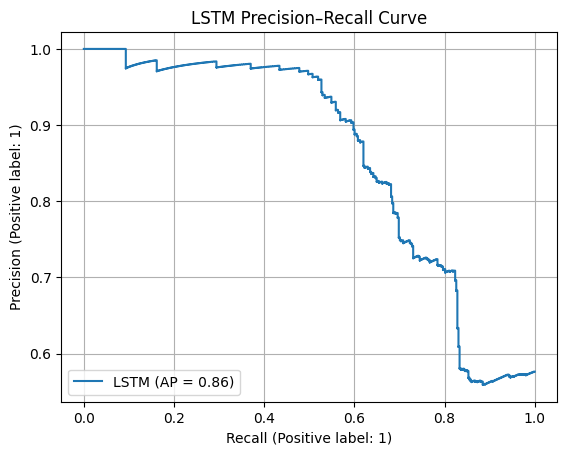

In [70]:
# Build sequences for ALL non-test stays (cv_pool_df)
X_train_all, y_train_all = build_sequences(cv_pool_df, feature_cols, label_col, seq_len)
X_test,      y_test      = build_sequences(test_df,    feature_cols, label_col, seq_len)

model = LSTMClassifier(
    input_dim=input_dim,
    hidden_dim=best_cfg["hidden_dim"],
    num_layers=best_cfg["num_layers"],
    dropout=best_cfg["dropout"],
)

# Train longer now (e.g., 20 epochs)
_ = train_one_model(
    model,
    (X_train_all, y_train_all),
    (X_test, y_test),   # just to reuse, but we won't look at this val result
    n_epochs=20,
    lr=best_cfg["lr"],
    device=device
)

# Final test evaluation
model.eval()
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    logits_test = model(X_test.to(device))
    test_loss = criterion(logits_test, y_test.to(device)).item()

    probs_test  = torch.sigmoid(logits_test).cpu().numpy()
    y_true_test = y_test.numpy()

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score

test_auc = roc_auc_score(y_true_test, probs_test)
test_ap  = average_precision_score(y_true_test, probs_test)

# Accuracy (0.5 threshold)
test_pred = (probs_test >= 0.5).astype(int)
test_acc  = (test_pred == y_true_test).mean()

print(f"\n=== FINAL TEST PERFORMANCE ===")
print(f"Loss:     {test_loss:.4f}")
print(f"Accuracy: {test_acc:.3f}")
print(f"ROC-AUC:  {test_auc:.3f}")
print(f"PR-AUC:   {test_ap:.3f}")

# --- Precision–Recall Curve ---
PrecisionRecallDisplay.from_predictions(
    y_true_test,
    probs_test,
    name="LSTM"
)
plt.title("LSTM Precision–Recall Curve")
plt.grid(True)
plt.show()

In [71]:
# # Make sure merged is sorted
# merged = merged.sort_values(["stay_id", "charttime"]).reset_index(drop=True)

# label_col = "Deterioration_next6h"  # or Event_next6h if you prefer

# # Unique stay_ids
# stay_ids = merged["stay_id"].unique()
# np.random.seed(42)
# np.random.shuffle(stay_ids)

# n = len(stay_ids)
# train_ids = stay_ids[: int(0.7 * n)]
# val_ids   = stay_ids[int(0.7 * n): int(0.85 * n)]
# test_ids  = stay_ids[int(0.85 * n):]

# train_df = merged[merged["stay_id"].isin(train_ids)].copy()
# val_df   = merged[merged["stay_id"].isin(val_ids)].copy()
# test_df  = merged[merged["stay_id"].isin(test_ids)].copy()

# print(len(train_df), len(val_df), len(test_df))


In [72]:
# # Normalize

# scaler = StandardScaler()
# scaler.fit(train_df[feature_cols])

# train_df[feature_cols] = scaler.transform(train_df[feature_cols])
# val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
# test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

In [73]:
# # padded sequences

# def create_sequences(df, feature_cols, label_col, seq_len):
#     X, y = [], []

#     df = df.sort_values(["stay_id", "charttime"]).reset_index(drop=True)

#     for stay_id, group in df.groupby("stay_id"):
#         group = group.reset_index(drop=True)
#         F = group[feature_cols].values
#         L = group[label_col].values

#         # need at least seq_len + 1 points to have one label after window
#         if len(group) <= seq_len:
#             continue

#         for i in range(len(group) - seq_len):
#             X.append(F[i:i+seq_len])       # (seq_len, num_features)
#             y.append(L[i+seq_len])         # label at time after window

#     return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# seq_len = 24

# X_train, y_train = create_sequences(train_df, feature_cols, label_col, seq_len)
# X_val,   y_val   = create_sequences(val_df,   feature_cols, label_col, seq_len)
# X_test,  y_test  = create_sequences(test_df,  feature_cols, label_col, seq_len)

# print("Train:", X_train.shape, y_train.shape)
# print("Val:  ", X_val.shape,   y_val.shape)
# print("Test: ", X_test.shape,  y_test.shape)

# print("Event prevalence (train):", y_train.mean())


In [74]:
# class SeqDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.from_numpy(X)  # (N, seq_len, num_features)
#         self.y = torch.from_numpy(y)  # (N,)
#     def __len__(self):
#         return len(self.X)
#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# train_ds = SeqDataset(X_train, y_train)
# val_ds   = SeqDataset(X_val,   y_val)
# test_ds  = SeqDataset(X_test,  y_test)

# batch_size = 64

# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
# test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [75]:
# # Define LSTM

# class LSTMDeterioration(nn.Module):
#     def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.2):
#         super().__init__()
#         self.lstm = nn.LSTM(
#             input_size=input_dim,
#             hidden_size=hidden_dim,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout if num_layers > 1 else 0.0,
#         )
#         self.fc = nn.Linear(hidden_dim, 1)  # binary logit output

#     def forward(self, x):
#         # x: (batch, seq_len, input_dim)
#         out, (h_n, c_n) = self.lstm(x)
#         # use last hidden state from final layer
#         h_last = h_n[-1]          # (batch, hidden_dim)
#         logit = self.fc(h_last)   # (batch, 1)
#         return logit.squeeze(1)   # (batch,)


In [76]:
# #Instantiate the model + loss + optimizer

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# input_dim = X_train.shape[2]
# model = LSTMDeterioration(input_dim=input_dim, hidden_dim=64, num_layers=1, dropout=0.2)
# model = model.to(device)

# # Class imbalance handling via pos_weight
# pos_frac = y_train.mean()
# neg_frac = 1.0 - pos_frac
# pos_weight = torch.tensor(neg_frac / pos_frac, dtype=torch.float32).to(device)
# print("pos_weight:", pos_weight.item())

# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [77]:
# # Training + validation loop

# def run_epoch(model, loader, optimizer=None):
#     is_train = optimizer is not None
#     model.train(is_train)

#     all_logits = []
#     all_targets = []
#     total_loss = 0.0

#     for X_batch, y_batch in loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         logits = model(X_batch)
#         loss = criterion(logits, y_batch)

#         if is_train:
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         total_loss += loss.item() * len(X_batch)
#         all_logits.append(logits.detach().cpu())
#         all_targets.append(y_batch.detach().cpu())

#     all_logits = torch.cat(all_logits).numpy()
#     all_targets = torch.cat(all_targets).numpy()

#     probs = 1 / (1 + np.exp(-all_logits))
#     preds = (probs >= 0.5).astype(int)

#     acc = accuracy_score(all_targets, preds)
#     try:
#         auc = roc_auc_score(all_targets, probs)
#     except ValueError:
#         auc = np.nan
#     try:
#         ap = average_precision_score(all_targets, probs)
#     except ValueError:
#         ap = np.nan

#     avg_loss = total_loss / len(loader.dataset)
#     return avg_loss, acc, auc, ap


In [78]:
# n_epochs = 50
# best_val_auc = -np.inf
# best_state = None

# for epoch in range(1, n_epochs+1):
#     train_loss, train_acc, train_auc, train_ap = run_epoch(model, train_loader, optimizer)
#     val_loss,   val_acc,   val_auc,   val_ap   = run_epoch(model, val_loader, optimizer=None)

#     print(
#         f"Epoch {epoch:02d} | "
#         f"Train loss {train_loss:.4f}, AUC {train_auc:.3f}, AP {train_ap:.3f} | "
#         f"Val loss {val_loss:.4f}, AUC {val_auc:.3f}, AP {val_ap:.3f}"
#     )

#     if val_auc > best_val_auc:
#         best_val_auc = val_auc
#         best_state = model.state_dict()


In [79]:
# if best_state is not None:
#     model.load_state_dict(best_state)

# test_loss, test_acc, test_auc, test_ap = run_epoch(model, test_loader, optimizer=None)

# print("\n=== Test performance ===")
# print(f"Loss: {test_loss:.4f}")
# print(f"Accuracy: {test_acc:.3f}")
# print(f"ROC-AUC: {test_auc:.3f}")
# print(f"PR-AUC:  {test_ap:.3f}")

# first run
# Loss: 0.6862
# Accuracy: 0.733
# ROC-AUC: 0.786
# PR-AUC:  0.703